In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib.lines as mlines

import logging
import pprint
import os
import re
import math
import time

from IPython.display import Audio
from IPython.core.display import display
import sounddevice as sd
from scipy.io import wavfile

import warnings
warnings.filterwarnings("ignore")

from music21 import converter, corpus, instrument, midi, note, chord, pitch, roman, stream
import mido
from mido import Message, MidiFile, MidiTrack

/var/folders/_n/q60hz2jn525c1wh33dn64zfc0000gn/T/ipykernel_54524/4129874949.py:14: DeprecationWarning: Importing display from IPython.core.display is deprecated since IPython 7.14, please import from IPython display
  from IPython.core.display import display


### 1. Convert note events to timeseries [t,note,vel]
eg. [[0,'C3',23],[2,'D3',56],[35,'D#3',55],[102,'C3',12]]


In [2]:
# returning all note on events from file in the form [[t,note,vel],[t,note,vel],[t,note,vel],...]
def midi_to_timeseries(midiPath):
    
    time_notes = []
#     midiFile = converter.parse(midiPath)
    uniqueTypes = [128,144,176]
    with open(midiPath) as midi_events:
        for line in midi_events:
            processedLine = line.split(" ")
    
            processedLine[0] = int(processedLine[0])
            processedLine[1] = int(processedLine[1], 16)

            if processedLine[1] not in uniqueTypes:
                print("unexpected event type got! ", processedLine[1])

            #    MIDI EVENT TYPES
            #    0x80 (hex)      128 (decimal)    Note Off
            #    0x90 (hex)      144 (decimal)    Note On
            #    0xB0 (hex)      176 (decimal)    Continuous Controller

            # processedLine[2] is note
            processedLine[2] = int(processedLine[2], 16)

            # processedLine[3] is velocity
            processedLine[3] = int(processedLine[3],16)

            if processedLine[1] == 144:
                time_notes.append([processedLine[0], processedLine[2], processedLine[3]])
                
    return time_notes



In [3]:
# generate dataframe of snippets
midiPath = './midi-recordings/ladispute.txt'
time_notes = midi_to_timeseries(midiPath)
#plot time_notes?

### STEP 2: Define a simplest similarity metric 

Asumptions & notes: 

-> minimal mistakes (wrong note gets 0 score)

-> similar spped (time is penalized by time diff)

-> time error as absolute not percentage

-> multiple notes can be played together (so not compared by order)

-> done wrt time not note events (timeseries) is this best way to represent notes? maybe as buckets?

-> ignoring vel

-> discriminate between octaves

-> traversing fixed time for targets (doesn't take into account small time changes?)
    
-> fixed absolute threshold 

-> target goes uptil current time - 100ms (to remove same timestamp matches)

-> source hop 500ms, target hop 100ms

##### Questions:
-> Long sequence with lower score or shorter sequence with higher score?

-> When confident in match?

-> Plot best match score vs time?

-> Calculate % time at least 1 match is found

-> Make more recordings to test

-> Idea: for speed change. take any similar note set and scale time by total time to play the set.\

-> Fixed absolute threshold or % of length. also offset/ curr note? pedal? vel?

-> traversing fixed time for targets (doesn't take into account small time changes?) Is this right?

-> Take into account length in similarity score

-> Need to check different values for:
    
    penalty for time change/ min distance/ wrt penalty for wrong note
    
    threshold
    
    min matches

In [46]:
def musical_similarity(tf1, tf2, disp = False):
    """ Function that calculates similarity score between 2 snippets
    eg [[-17,60],[-100,62],[-101,64],[-300,60]] and [[-20,60],[-50,61],[-101,64],[-102,62],[-307,60]]

    Args:
        tf1: first snippet [[t,note,vel],[t,note,vel],[t,note,vel],...]
        tf2: second snippet [[t,note,vel],[t,note,vel],[t,note,vel],...]

    Returns:
        score: similarity - integer between 0 to 1

    """
    # updating time stamps wrt first note for tf1
    sequence1 = []
    first = tf1[0] # Timestamp of first note
    for el in tf1: # Save time delta of each note in sequence (relative to first note)
        sequence1.append([el[0]-first[0],el[1]])

    seq_1_time_del = (tf1[-1][0] - first[0]) * 1.0

    # updating time stamps wrt first note for tf2
    sequence2 = []
    first = tf2[0]
    for el in tf2:
        sequence2.append([el[0]-first[0],el[1]])

    seq_2_time_del = tf2[-1][0] - first[0]

    time_ratio = seq_2_time_del / seq_1_time_del

    # Calculating score array by comparing every note from each sequence and taking the best match
    score = []
    for event1 in range(len(sequence1)):
        max_score = 0 # score for best match with event1
        max_el = -1 # note index of best match
        for event2 in range(len(sequence2)):
            s = note_similarity(sequence1[event1],sequence2[event2],time_ratio)
            if s > max_score:
                max_score = s
                max_el = event2

        # If we get a non-zero similarity score, we assume that the
        # two notes "match", and remove them from the potential match
        # pool
        if max_score != 0: # if match found
            score.append(max_score)
            sequence1[event1] = [] # setting to empty because a match for this note has already been found
            sequence2[max_el] = []

    # For every pair of notes in both sequences, if a match was not found, add a zero score
    for i in range((len(sequence1) + len(sequence2) - (2*len(score)))//2):
        score.append(0)

    if disp:
        print("Scores:",score)

    # Similarity of the two sequences is the mean of the note similarity scores
    score = np.mean(score)

    # including length in score, if at least 5 notes
    if len(tf1)>5:
        score += score * seq_1_time_del/100000 # 10 seconds yield 10% increase

    if score>1:
        score = 1

    return score
     
def note_similarity(note1,note2,ratio):
    """ Function that calculates similarity score between 2 notes - depending on note value and time
    
    Args:
        note1: first note to compare [t,note,vel]
        note2: second note to compare [t,note,vel]
    
    Returns:
        score: similarity - integer between 0 to 1
    
    """
    # score is linear with time difference between notes
    
    #     strictness = 0.2 # note within 10% time difference
    min_dist = 400 * ratio # acceptable time difference for same note
    
    if (not note1) or (not note2):
        return 0
    if note1 == note2: # exact match!
        return 1
    if note1[1] != note2[1]: # different notes
        return 0
    
    # check if acceptable match wrt time - score is linear with time stamp difference
    time_diff = abs(note1[0] - note2[0])
    #     print(time_diff)
    if  time_diff < min_dist:
        return 1 - time_diff/min_dist
    else:
        return 0
    
def calculate_similarity(source, targets, currTime):
    """ Function that calls musical similarity on each target and returns all matches
    
    Args:
        source: list of notes at current time [[t,note,vel],[t,note,vel],[t,note,vel],...]
        targets: multiple lists of same length as source from 0 to currTime
        currTime: time stamp at which we are searching for matches
    
    Returns:
        matches: list of matches [[currTime, pastTime1, score1], [currTime, pastTime2, score2],...]

    """
    matches = []
    count = 0
    for target in targets:
        score = musical_similarity(source, target)
        if score:
            matches.append([currTime, target[0][0], score])
        count += 1
        
    return matches

def calculate_similarity_id(notes, source_id, currTime):
    """ Function that calls musical similarity on targets generated for a source_id.
        Targets start at every index of notes array and has same number of notes as source.
    
    Args:
        notes: list of all notes from a recording [[t,note,vel],[t,note,vel],[t,note,vel],...]
        source_id: indices of note array corresponding to current time snippet (source_id_start>source_id_end) 
                   [source_id_start, source_id_end]
        currTime: time stamp at which we are searching for matches (ms)
    
    Returns:
        matches: list of matches [[currTime, pastTime1, score1], [currTime, pastTime2, score2],...]
    
    """
    matches = []
    source_id_start, source_id_end = source_id
    snip_length = source_id_start - source_id_end
    
    for target_id_start in range(snip_length, source_id_start+1):
        target_id_end = target_id_start - snip_length # pick target_id_end by number of notes in snippet
        score = musical_similarity(notes[source_id_end:source_id_start], notes[target_id_end:target_id_start])
        if score:
            matches.append([currTime, notes[target_id_start][0], score])
        
    return matches

def calculate_similarity_time(notes, source_id, currTime, disp=False):
    """ Function that calls musical similarity on targets generated for a source_id.
        Target snips start at every 100 ms, and has same time length as source.
    
    Args:
        notes: list of all notes from a recording [[t,note,vel],[t,note,vel],[t,note,vel],...]
        source_id: indices of note array corresponding to current time snippet (source_id_start>source_id_end) 
                   [source_id_start, source_id_end]
        currTime: time stamp at which we are searching for matches (ms)
        disp: boolean whether to print each match (defaults True)
    
    Returns:
        matches: list of matches [[currTime, pastTime1, score1], [currTime, pastTime2, score2],...] 
    
    """
    matches = []
    last_id = 0 # track previous end index of target
    source_id_start, source_id_end = source_id
    source_end = notes[source_id_end][0] # start and end time stamps of source
    length_ms = currTime - source_end #in milliseconds
    
    for target_start in range(length_ms, currTime-500, 100):
        target_end = target_start - length_ms # pick target_end by time length of course snip
        
        # finding new end index
        for i in range(last_id,len(notes)):
            if notes[i][0] >= target_end:
                target_id_end = i
                break
             
        # finding new start index
        for i in range(target_id_end,len(notes)):
            if notes[i][0] > target_start:
                target_id_start = i
                break
                
        if target_id_end == target_id_start:
            continue
            
        score = musical_similarity(notes[source_id_end:source_id_start], notes[target_id_end:target_id_start])
        if score:
            
            # Dsiplaying matches > 0.7 if disp is True
            if disp and score>0.7:
                display_match(notes, source_id_start, source_id_end, target_id_start, target_id_end, score, source_end, notes[target_id_end][0])
                display_snippet_plot(notes, source_id_start, source_id_end, target_id_start, target_id_end, score, source_end, notes[target_id_end][0])

                #                play_match(currTime, source_end, target_start, target_end)
#                 predict(notes, source_id_start, source_id_end, target_id_start, target_id_end, currTime, target_start)

            matches.append([currTime, target_start, score])
        last_id = target_id_end
            
    return matches

def get_source_targets_index(snips, start_index, min_notes, max_notes, min_time, offset=0):
    """ Function that generates source and target snippets using precomputed snips.
        Iterates over all note on events (not time).
    
    Args:
        snips: list of all note arrays of lengths min_notes to max_notes snip[1][2][3][4]
               1 - length of snip, 2 - start index from notes, 3 - index of note in array, 4 - [t, note, vel]
        start_index: start index of notes array - corresponding to current time
        min_notes: min number of notes for a valid sequence, integer
        max_notes: max note length for a snippet, integer
        min_time: min time length for a valid sequence, integer (ms)
        offset: used to find note snippets longer than min_length, integer, default=0
    
    Returns:
        source: list of notes at current time [[t,note,vel],[t,note,vel],[t,note,vel],...]
        targets: multiple lists of same length as source from 0 to currTime
    
    """
    for length in range(offset, max_notes-min_notes):
        if snips[length][start_index-min_notes-length][-1][0]-snips[length][start_index-min_notes-length][0][0]>=min_time:
            source = snips[length][start_index-min_notes-length]
            targets = snips[length][0:(start_index-min_notes-length+1)]
            return source, targets
        
    print("Error: Trying to access snippet length > max_notes")
    return None, None

def get_source_targets(snips, start_time, min_notes, max_notes, min_time, offset=0):
    """ Function that calculates start index for source, and calls get_source_targets_index to get the
        final snippets for source and targets.
    
    Args:
        snips: list of all note arrays of lengths min_notes to max_notes snip[1][2][3][4]
               1 - length of snip, 2 - start index from notes, 3 - index of note in array, 4 - [t, note, vel]
        start_time: start index of notes array - corresponding to current time
        min_notes: min number of notes for a valid sequence, integer
        max_notes: max note length for a snippet, integer
        min_time: min time length for a valid sequence, integer (ms)
        offset: used to find note snippets longer than min_length, integer, default=0
    
    Returns:
        source: list of notes at current time [[t,note,vel],[t,note,vel],[t,note,vel],...]
        targets: multiple lists of same length as source from 0 to currTime 
    
    """
    for i in range(len(snips[0])):
        if snips[0][i][0][0] > start_time:
            start_index = i
            break
    else:
        print("Error: Start time too large")
        return None, None
    
    if start_index<3:
        return None, None
    
    return get_source_targets_index(snips, start_index, min_notes, max_notes, min_time, offset)

def get_source_notes_index(notes, start_index, start_time, min_notes, max_notes, min_time):
    """ Function that ...
    
    Args:
        notes: list of all note arrays of lengths min_notes to max_notes snip[1][2][3][4]
               1 - length of snip, 2 - start index from notes, 3 - index of note in array, 4 - [t, note, vel]
        start_index: 
        start_time: start index of notes array - corresponding to current time
        min_notes: min number of notes for a valid sequence, integer
        max_notes: max note length for a snippet, integer
        min_time: min time length for a valid sequence, integer (ms)\
    
    Returns:
        source_id: 
    
    """
    for end_index in range(start_index-min_notes, start_index - max_notes - 1, -1):
        if start_time - notes[end_index][0] >= min_time:
            source_id = [start_index,end_index]
            return source_id
        
    print("Error: Trying to access snippet length > max_notes")
    return None

def get_source_notes(notes, start_time, min_notes, max_notes, min_time):
    """ Function that ...
    
    Args:
        snips: list of all note arrays of lengths min_notes to max_notes snip[1][2][3][4]
               1 - length of snip, 2 - start index from notes, 3 - index of note in array, 4 - [t, note, vel]
        start_time: start index of notes array - corresponding to current time
        min_notes: min number of notes for a valid sequence, integer
        max_notes: max note length for a snippet, integer
        min_time: min time length for a valid sequence, integer (ms)
        offset: used to find note snippets longer than min_length, integer, default=0
    
    Returns:
        matches: list of matches [[currTime, pastTime1, score1], [currTime, pastTime2, score2],...] 
    
    """
    for i in range(len(notes)):
        if notes[i][0] > start_time:
            start_index = i
            break
    else:
        print("Error: Start time too large")
        return None
    
    if start_index<3:
        return None
    
    return get_source_notes_index(notes, start_index, start_time, min_notes, max_notes, min_time)
   
def get_note(i):
    """ Function that converts note from integer to name
    Args:
        i: integer value corresponding to note
    Returns:
        note: note name, eg. "C4" 
    """
    
    # convert integer to note
    notes = ['C','C#/Db','D','D#/Eb','E','F','F#/Gb','G','G#/Ab','A','A#/Bb','B']
    return notes[i%12] + str(i//12 - 1)

def get_int(note):
    """ Function that converts note from name to integer
    Args:
        note: note name, eg. "C4"
    Returns:
        i: integer value corresponding to note
    """
    
    # convert integer to note
    temp = re.compile("([a-zA-Z]+)([0-9]+)")
    note = temp.match(note).groups()
    notes = {'C':0,'C#/Db':1,'C#':1,'Db':1,'D':2,'D#/Eb':3,'D#':3,'Eb':3,'E':4,'F':5,'F#/Gb':6,'F#':6,'Gb':6,'G':7,'G#/Ab':8,'Ab':8,'G#':8,'A':9,'A#/Bb':10,'A#':10,'Bb':10,'B':11}
    return notes[note[0]] + 12*(int(note[1])+1)

def predict(notes, source_id_start, source_id_end, target_id_start, target_id_end, curr_time, target_time):
    """ Function that 
    Args:
        note: note name, eg. "C4"
    Returns:
        i: integer value corresponding to note
    """
    
    # predicting 100ms of music
    time = target_time
    predeicted = [target_id_start]
    while time < target_time + 100:
        continue

def read_audio(file):
    """ Function that reads .wav file of midi recording and saves it to a global variable
    Args:
        file: .txt file with midi notes
    """
    
    global samplerate, piano_audio
    samplerate, piano_audio = wavfile.read(file)
    
def display_match(notes, source_start, source_end, target_start, target_end, score, sourceStart, targetStart):
    """ Function that displays the snippets if they match.
    Args:
        notes: note name, eg. "C4"
        source_start: 
        source_end: 
        target_start: 
        target_end: 
        score: 
        sourceStart: 
        targetStart: 
    """
    
    print("Score: ", score)
    print("Source({st}):  Target({tt}): ".format(st=notes[source_end][0], tt=notes[target_end][0]))
    for i in range(min(source_start-source_end, target_start-target_end)):
        print(notes[i+source_end][0]-sourceStart, get_note(notes[i+source_end][1]), end=", ")
        print(notes[i+target_end][0]-targetStart, get_note(notes[i+target_end][1]))
    for i in range(target_start-target_end, source_start-source_end):
        print(notes[i+source_end][0]-sourceStart, get_note(notes[i+source_end][1]), end=", \n")
    for i in range(source_start-source_end, target_start-target_end):
        print("        ,",notes[i+target_end][0]-targetStart, get_note(notes[i+target_end][1]))
        
    print("  Next notes: ")
    for i in range(5):
        print(notes[i+source_start][0]-sourceStart,get_note(notes[i+source_start][1]), end=", ")
        print(notes[i+target_start][0]-targetStart,get_note(notes[i+target_start][1]))
        
    print()
        
def play_match(source_start, source_end, target_start, target_end):
    """ Function that plays portion of audio file corresponding to each sequence of a match
    Args:
        source_start: 
        source_end: 
        target_start: 
        target_end: 
    """
    
    global piano_audio
    ss = source_start * samplerate // 1000
    se = source_end * samplerate // 1000
    te = target_end * samplerate // 1000
    ts = target_start * samplerate // 1000
    #Source
    sd.play(piano_audio[se:ss], samplerate, blocking = True)
    time.sleep(1)
    #Target
    sd.play(piano_audio[te:ts], samplerate, blocking = True)
    time.sleep(1)
    

In [136]:
def display_snippet_plot(notes, source_start, source_end, target_start, target_end, score, sourceStart, targetStart):
    plt.figure(figsize = (10,5))
    lenSource = source_start-source_end
    lenTarget = target_start-target_end
    timeStampSourceEnd = notes[(lenSource - 1)+source_end][0]-sourceStart
    timeStampTargetEnd = notes[(lenTarget - 1)+target_end][0]-targetStart
    
    if timeStampSourceEnd >= timeStampTargetEnd:
        xmax = timeStampSourceEnd
    else:
        xmax = timeStampTargetEnd
        
    # plt.xlim(0,xmax)
    plt.xlabel("Relative Snippet Time (in MS)")
    # yscale = ['C','C#/Db','D','D#/Eb','E','F','F#/Gb','G','G#/Ab','A','A#/Bb','B']
    # plt.yticks(range(0,len(yscale)),yscale)
    plt.ylabel("Note (Integer Representation)")
    title = "Snippet Plot:" + ", Source @ " + str(notes[source_end][0]) + " ms, Target @ " + str(notes[target_end][0]) + " ms, Score: " + str(round(score,4))
    plt.title(title)
    plt.locator_params(axis="both", integer=True, tight=True)

    sourceX = []
    sourceY = []
    targetX = []
    targetY = []
    for i in range(min(source_start-source_end, target_start-target_end)):
        sourceX.append(notes[i+source_end][0]-sourceStart)
        sourceY.append((notes[i+source_end][1]))
        targetX.append(notes[i+target_end][0]-targetStart)
        targetY.append((notes[i+target_end][1]))
    for i in range(target_start-target_end, source_start-source_end):
        sourceX.append(notes[i+source_end][0]-sourceStart)
        sourceY.append((notes[i+source_end][1]))
    for i in range(source_start-source_end, target_start-target_end):
        targetX.append(notes[i+target_end][0]-targetStart)
        targetY.append((notes[i+target_end][1]))
                       
    plt.plot(sourceX, sourceY, label="Source", marker=".")
    plt.plot(targetX, targetY, label="Target",linestyle='--', marker="*")
    plt.legend()
    plt.show()
    

In [137]:
# Zulip example to test similarity score
tf1 = [[-17,60],[-100,62],[-101,64],[-300,60]]
tf2 = [[-20,60],[-50,61],[-101,64],[-102,62],[-307,60]]

musical_similarity(tf1,tf2)

0.9950696864111499

In [138]:
# Snippet note length = 1
minNotes = 8
maxNotes = 30 # max length of snippet to be calculated
minTime = 1500 # min time in ms

# generate dataframe of snippets
snips = []
midiPath = './midi-recordings/ladispute.txt'
notes = midi_to_timeseries(midiPath)

for j in range(minNotes, maxNotes + 1):
    ind = j - minNotes
    snips.append([])
    for i in range(len(notes)+1-j):
        snip = notes[i: i+j]
        snips[ind].append(snip)


In [139]:
notes[-1][0]

729285

In [140]:
def time_to_index(notes, timestamp):
    for i in range(len(notes)):
        if notes[i][0] > timestamp:
            return i

def index_to_time(notes, index):
    return notes[index][0]

def index_to_sequence(notes, ids): # assume start>end & not include start for convention
    start_id, end_id = ids
    sequence = []
    for i in range(end_id,start_id):
        sequence.appaned(notes[i])
    return sequence

def time_to_sequence(notes, times): # assume start>end & not include start for convention
    start, end = times
    i = time_to_index(notes, end)
    sequence = []
    while i < len(notes):
        if notes[i][0]>=start:
            break
        sequence.append(notes[i])
        i += 1
    return sequence


0.9892138524413132


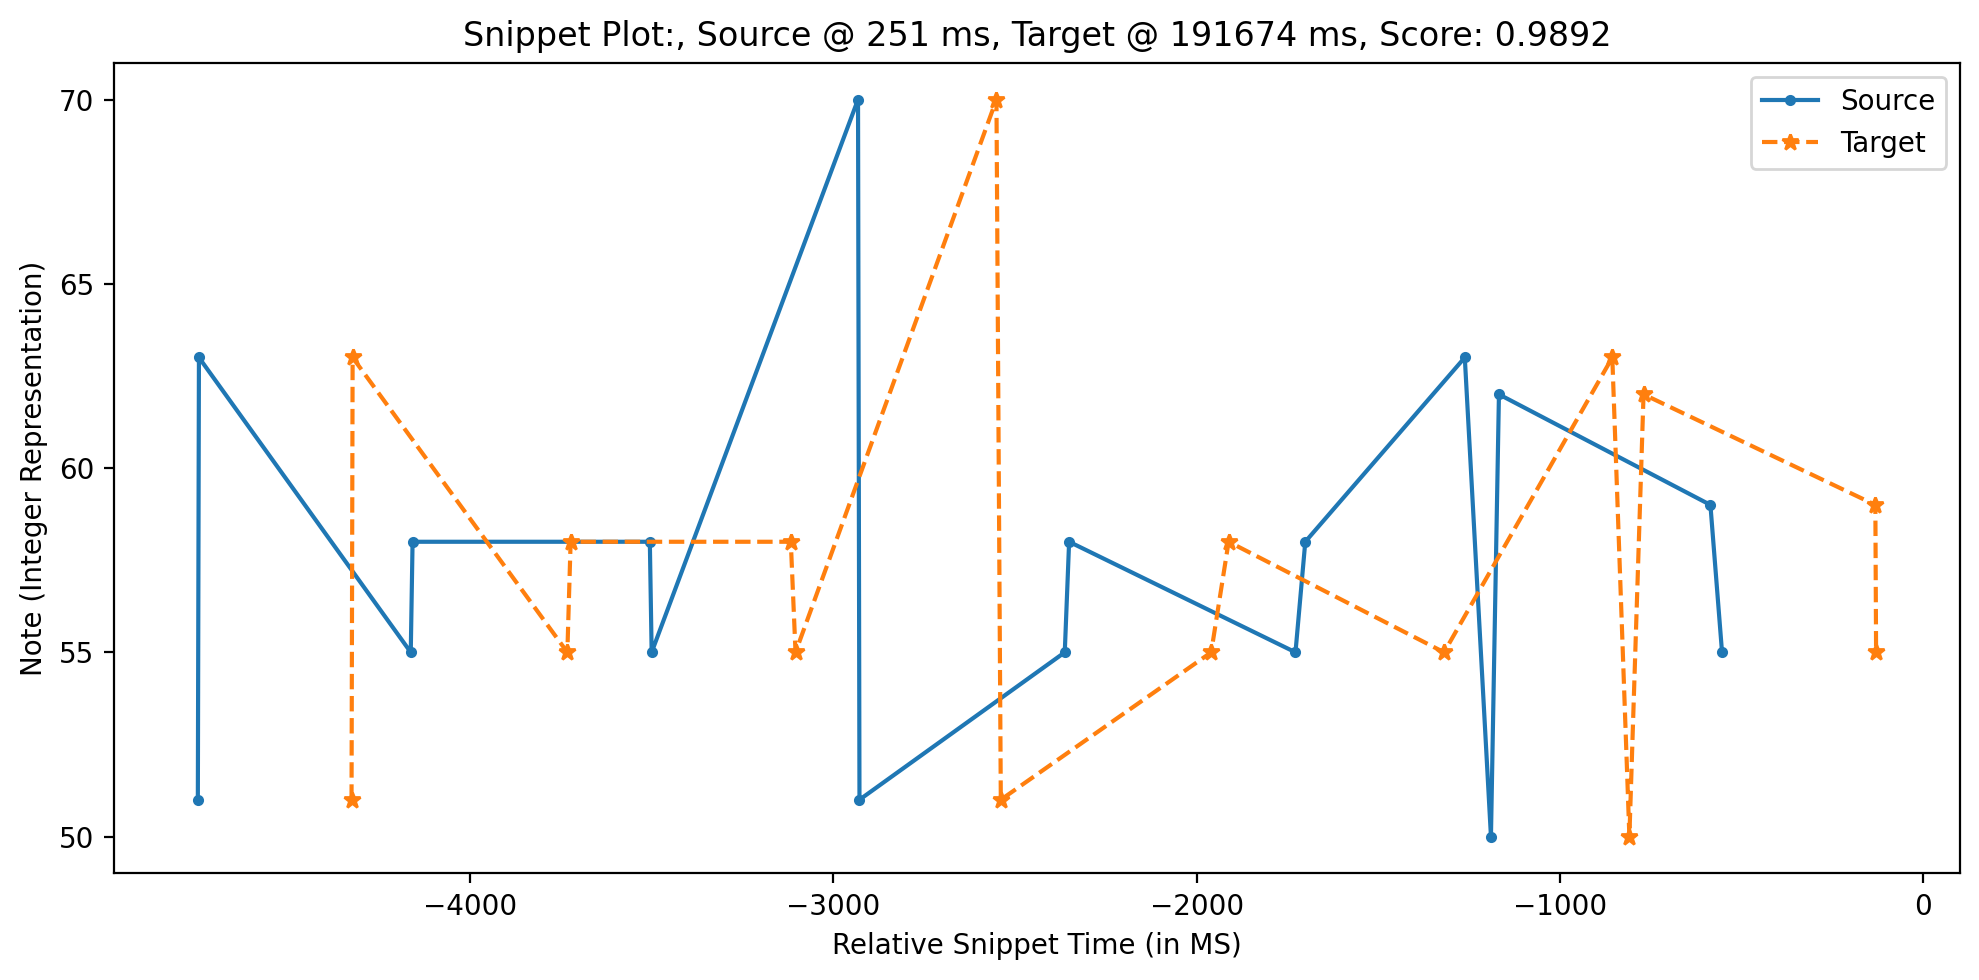

0.9531345953393678


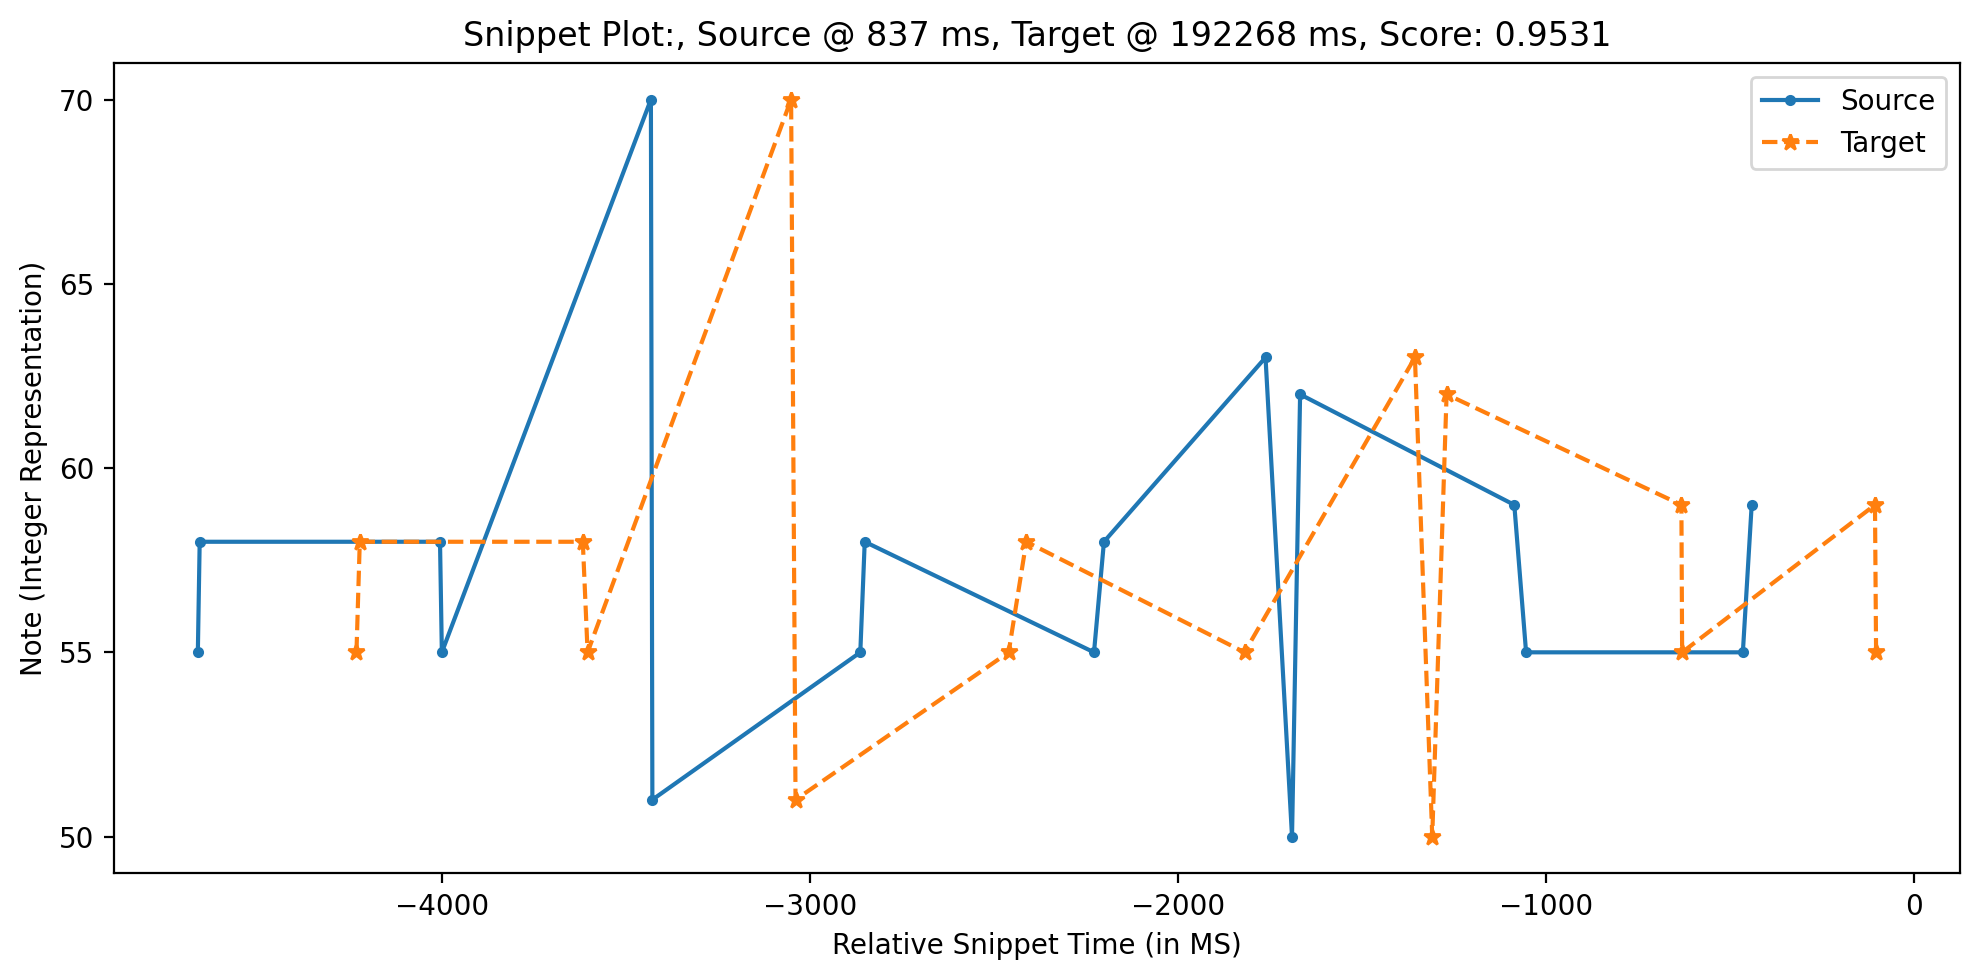

0.9064528209262948


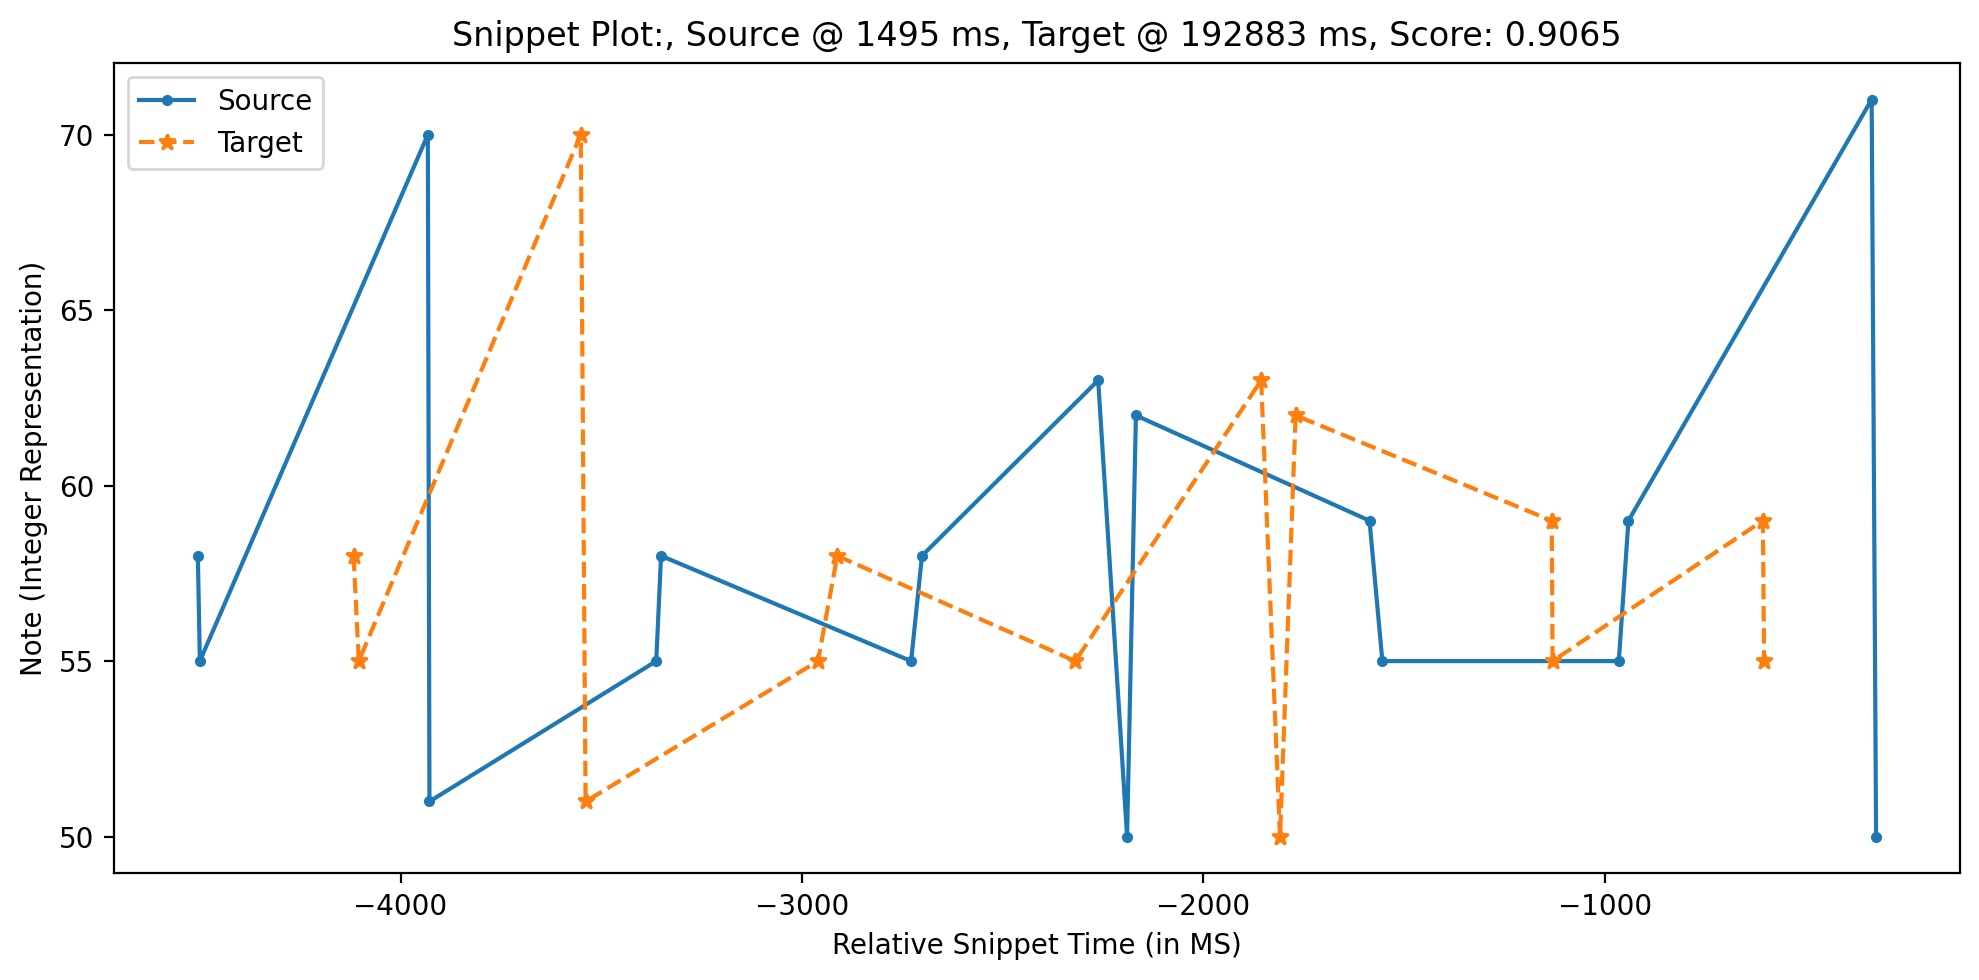

0.9010836195397837


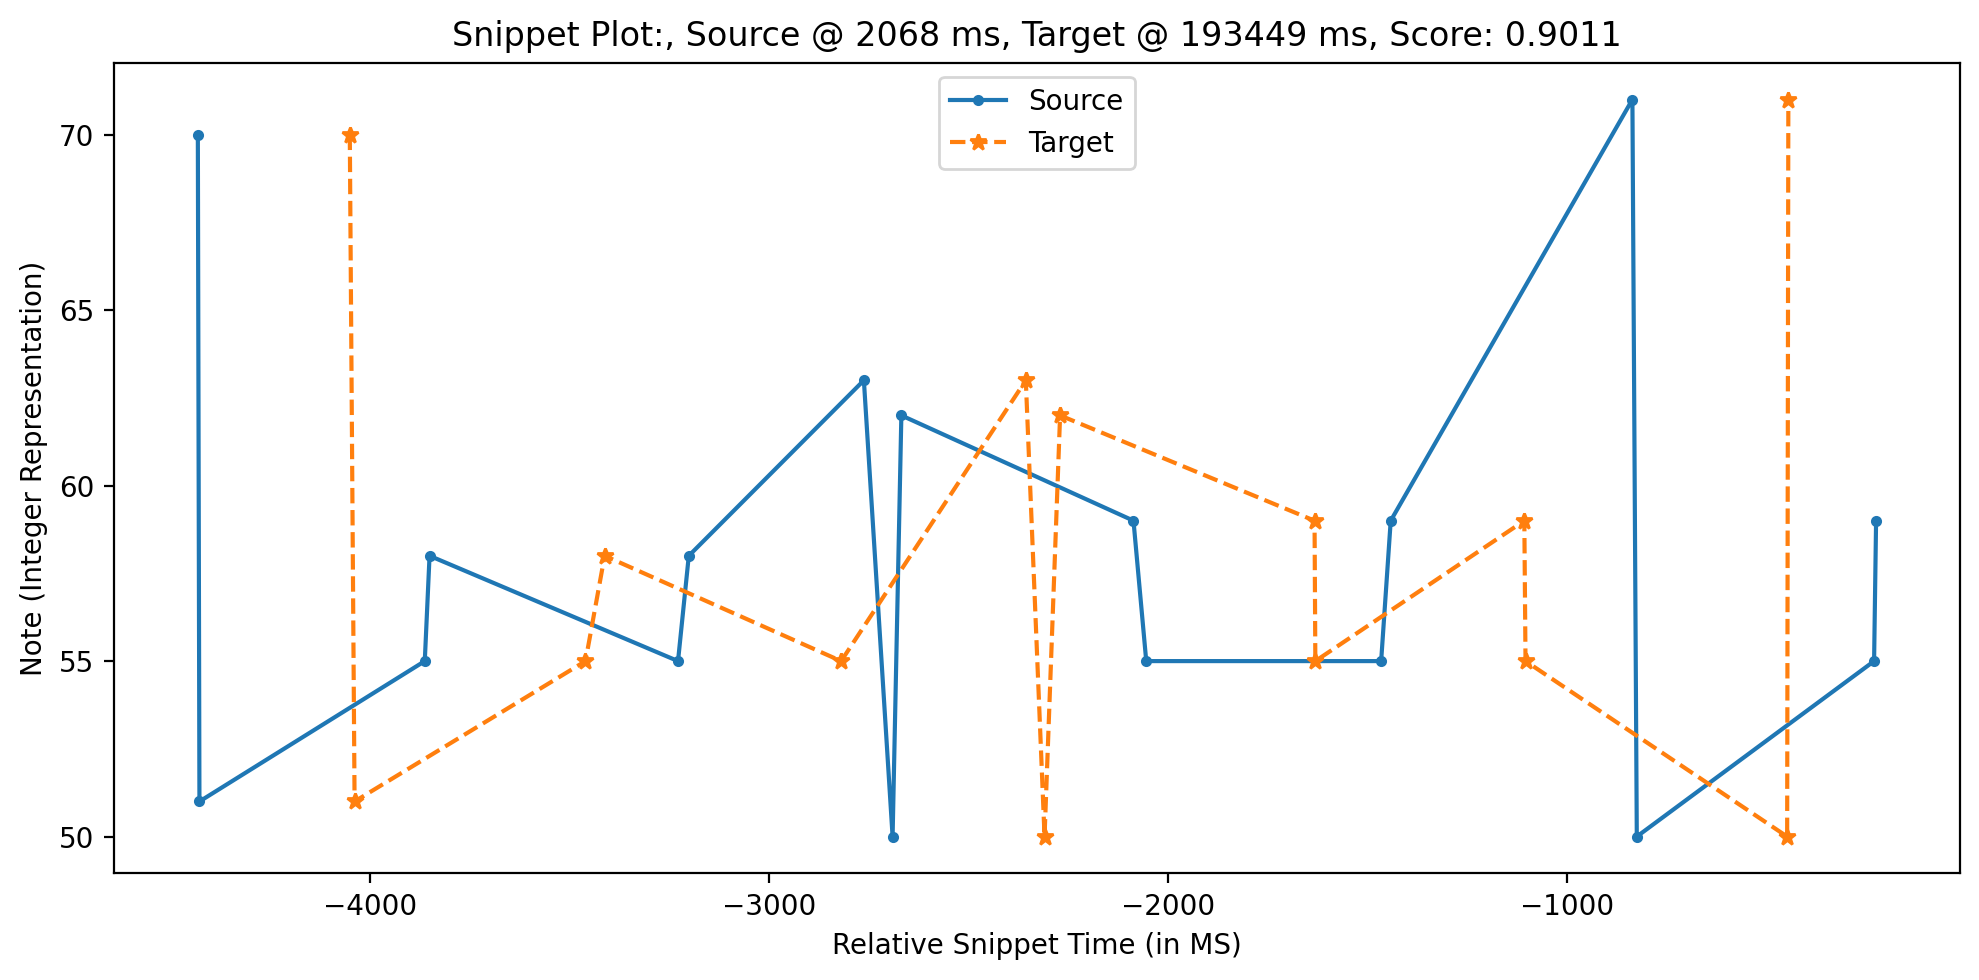

0.915385768786496


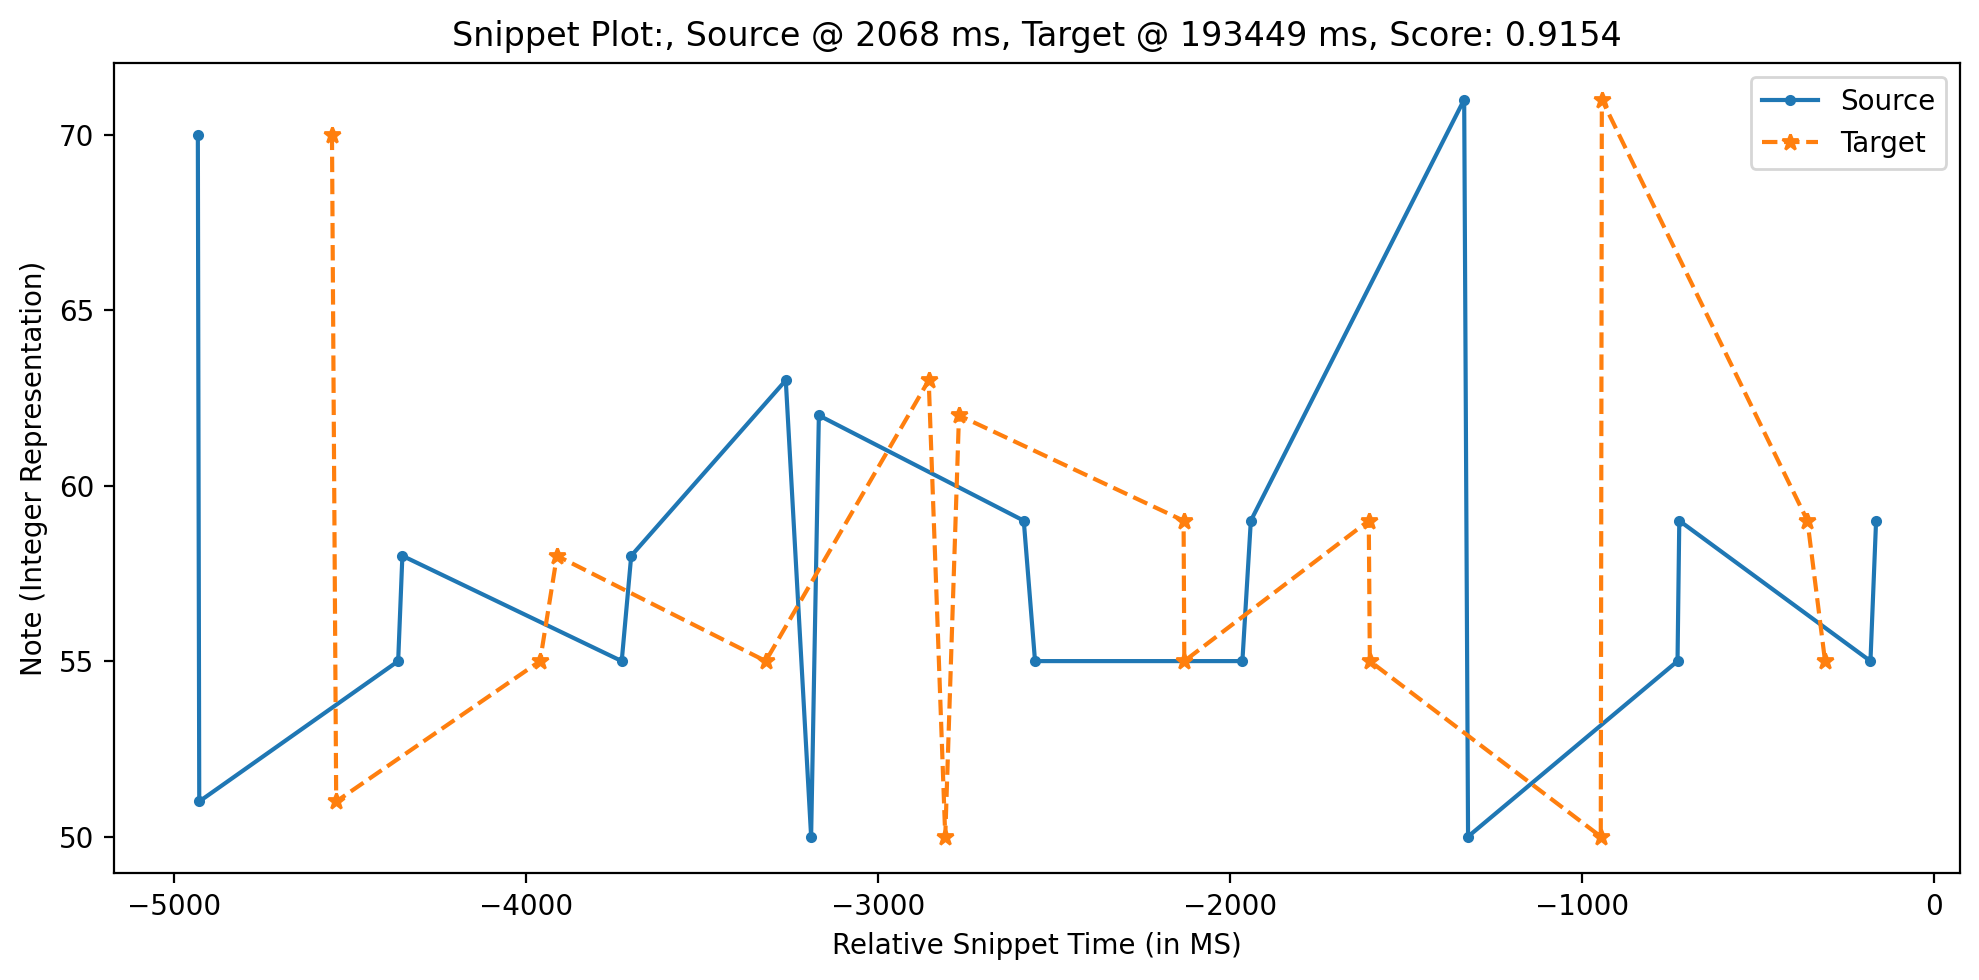

0.8078389117773337


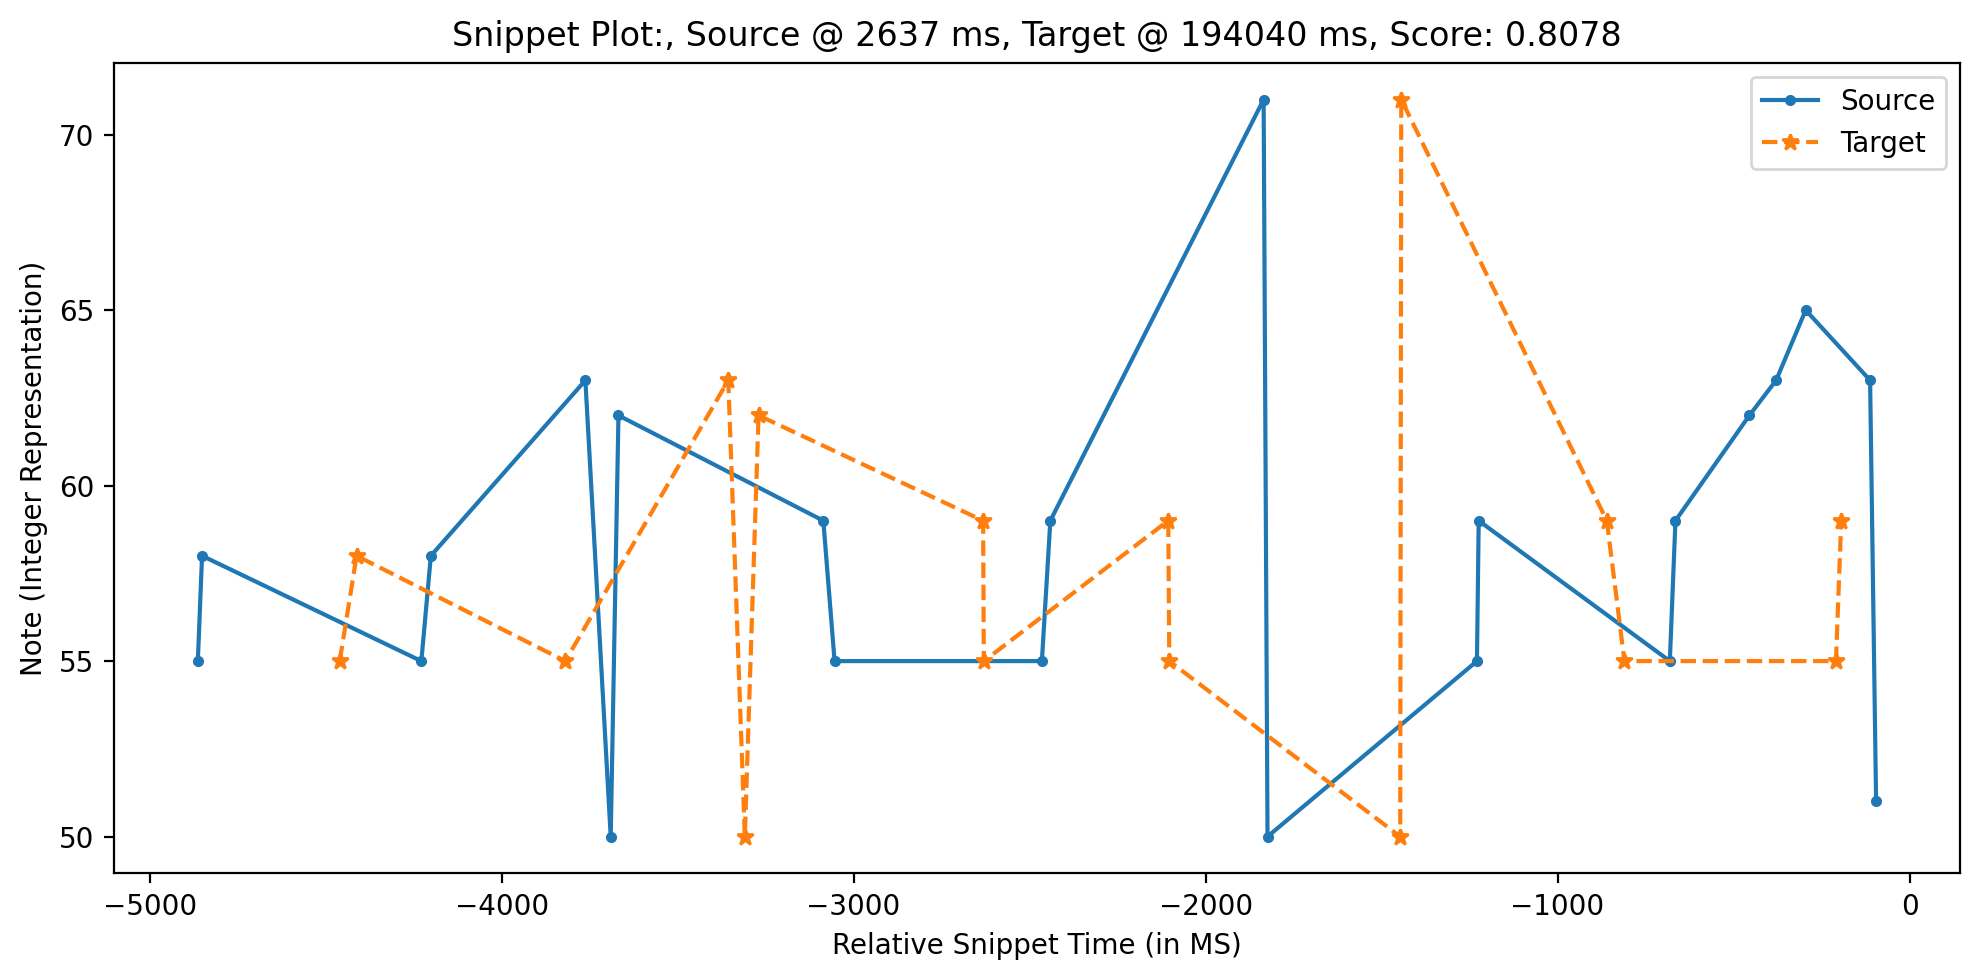

0.9543021943970903


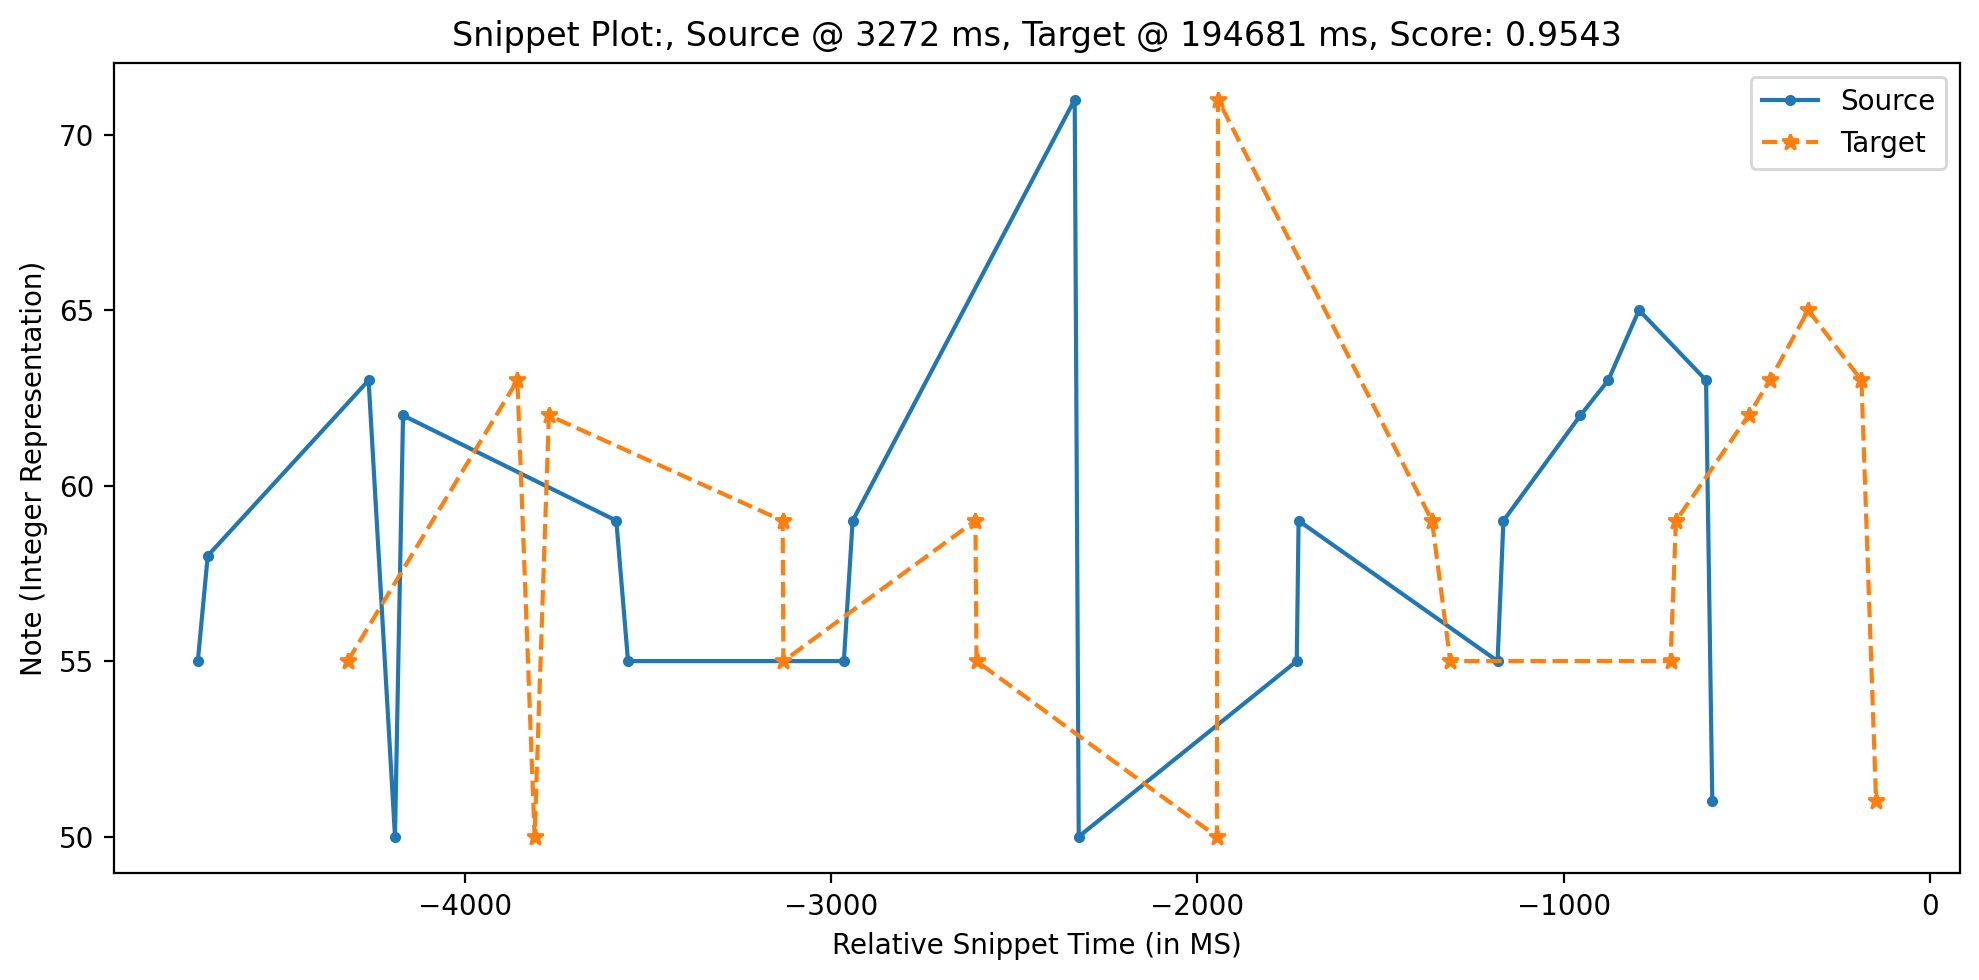

0.9535889579348203


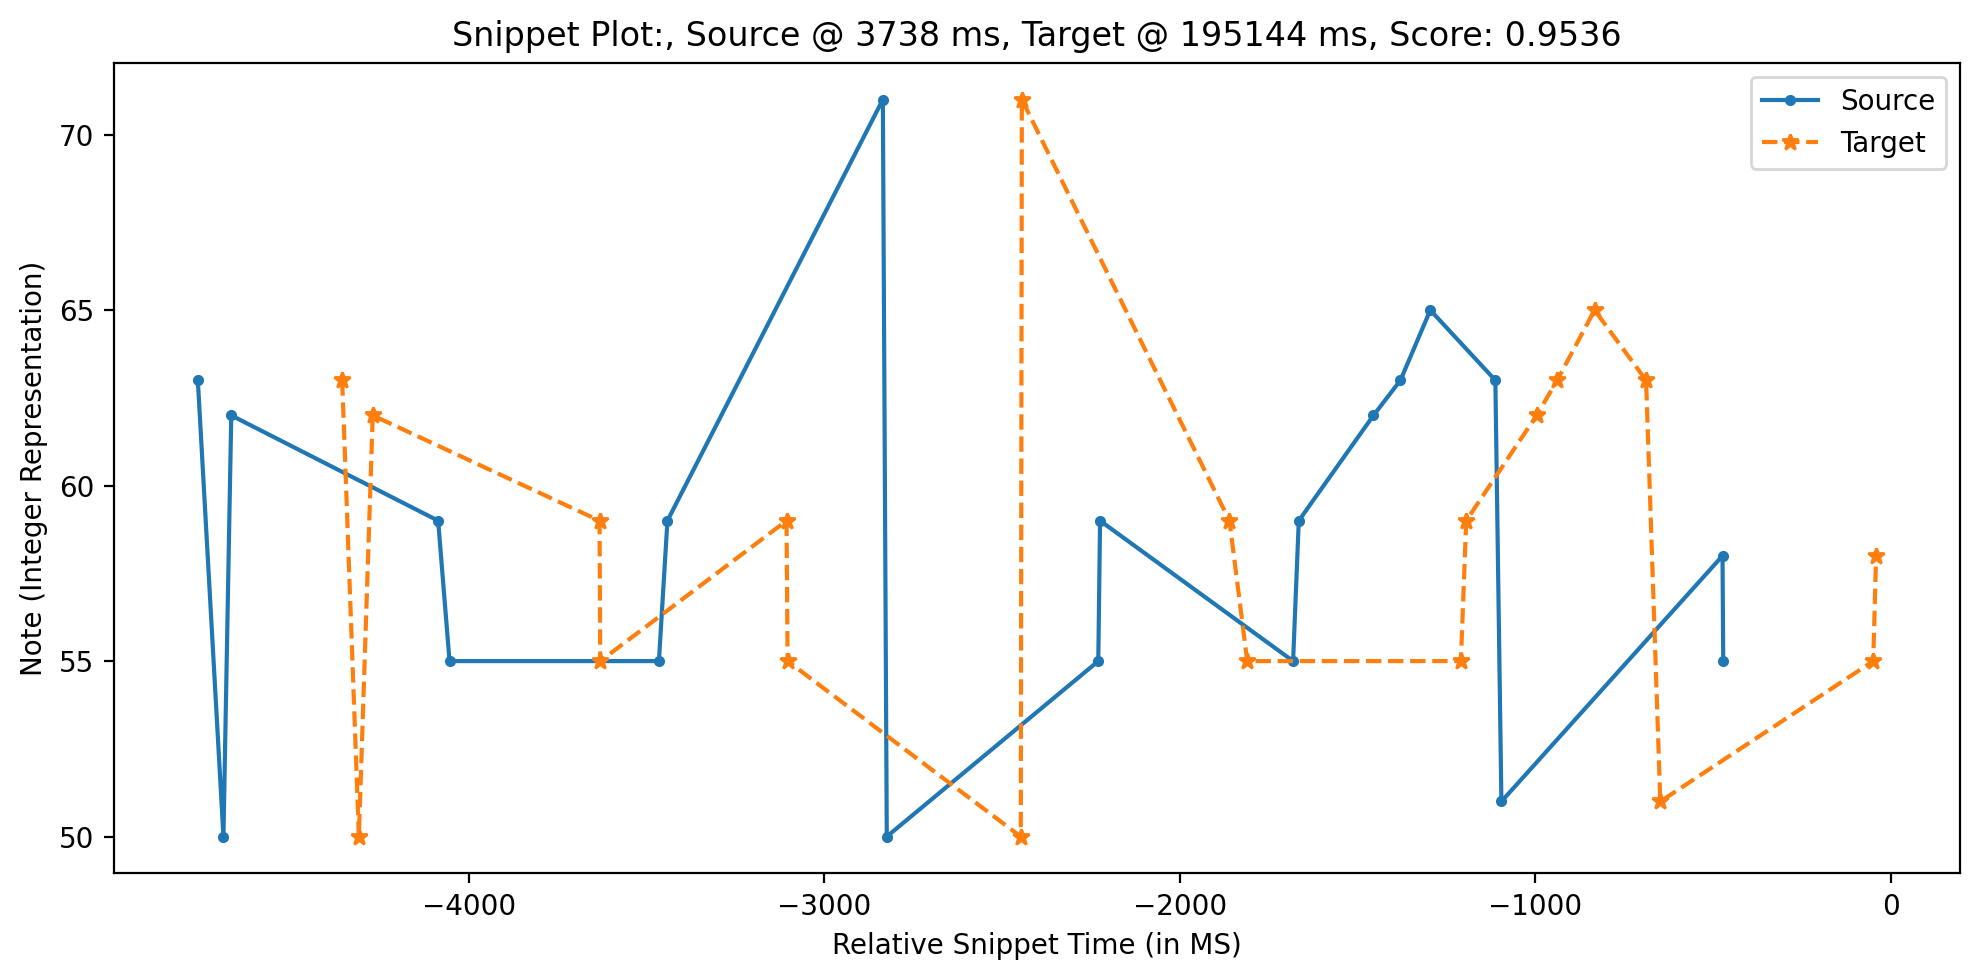

0.8730063267543859


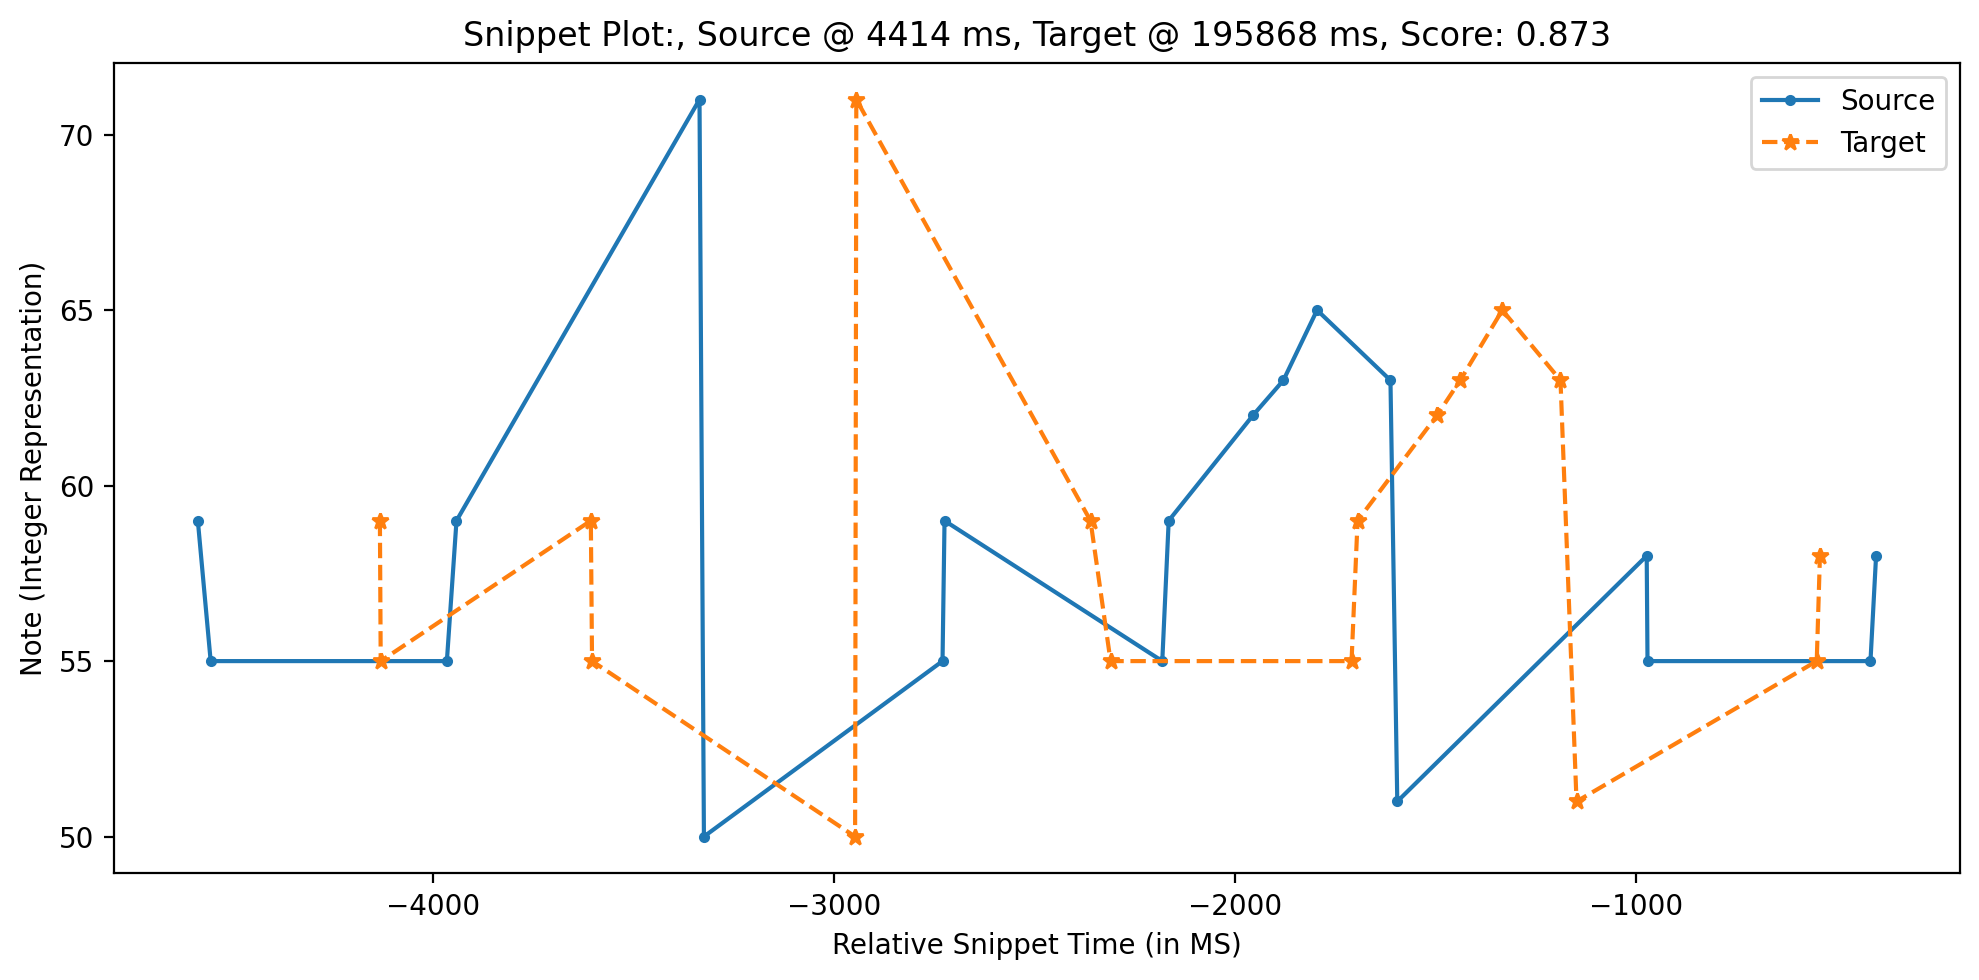

0.7792634419719908


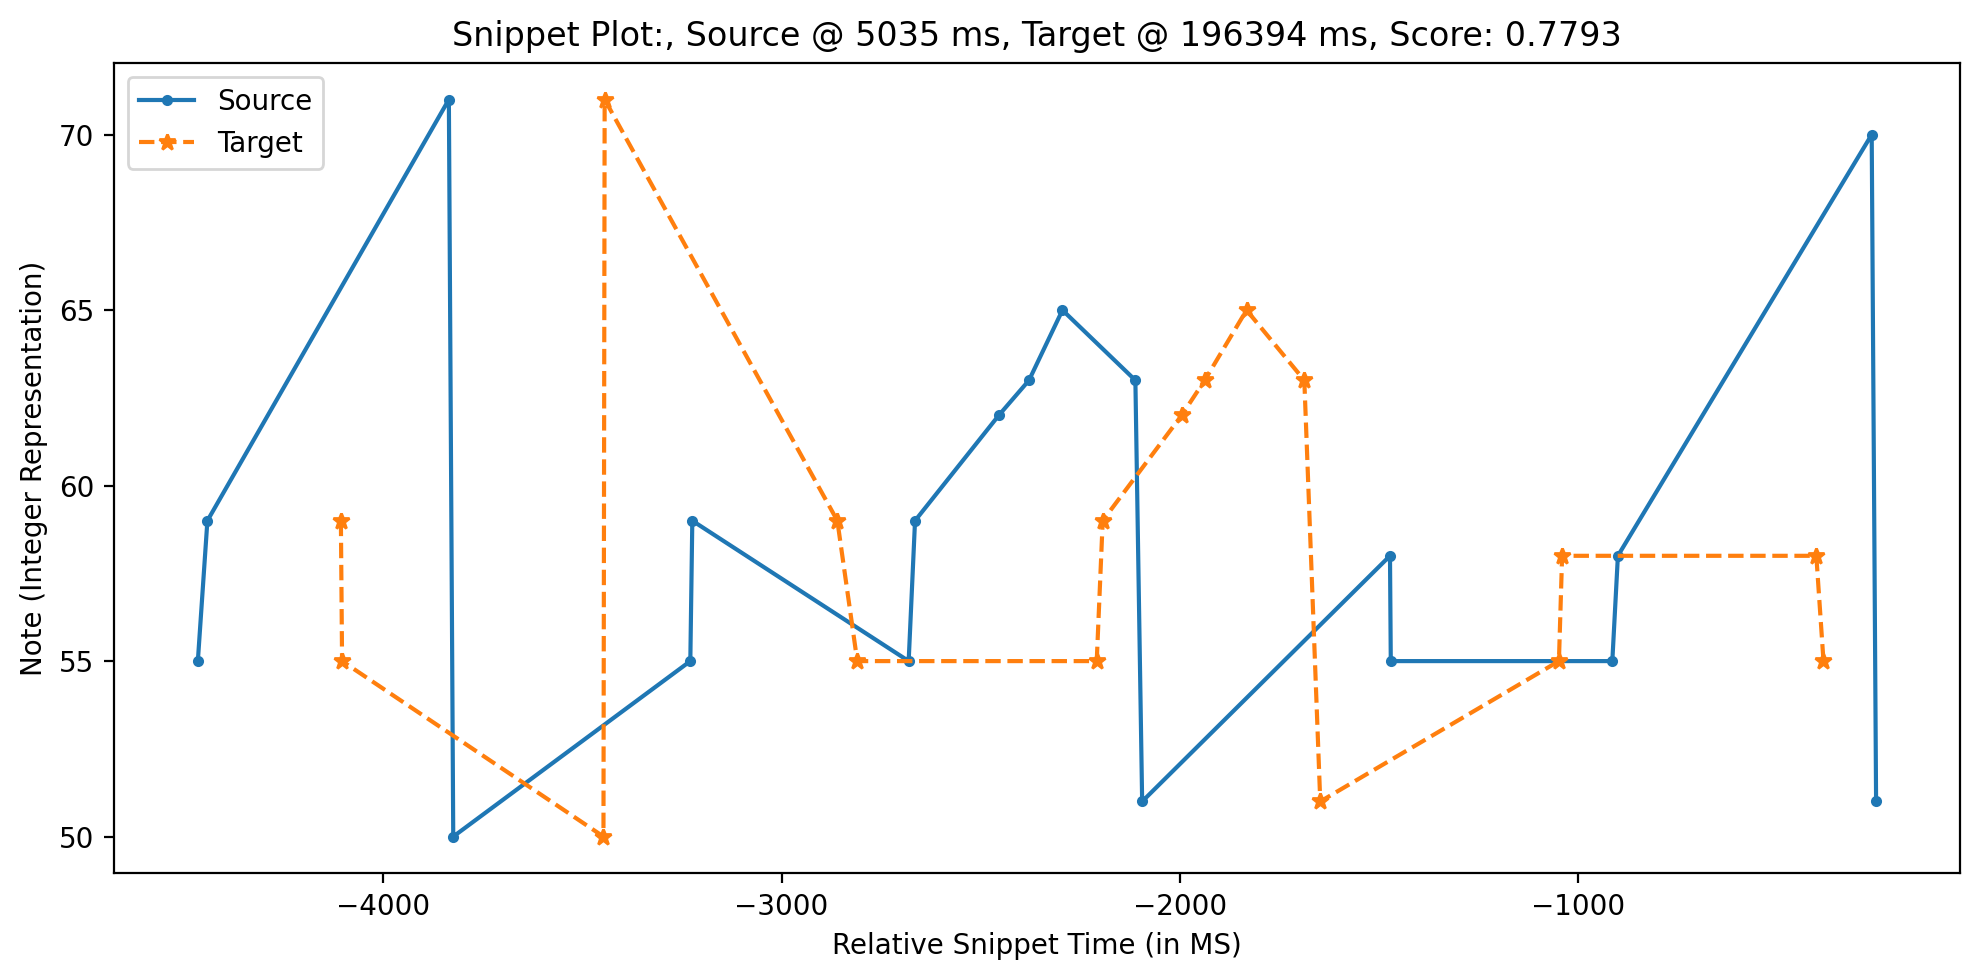

0.19596927682194665


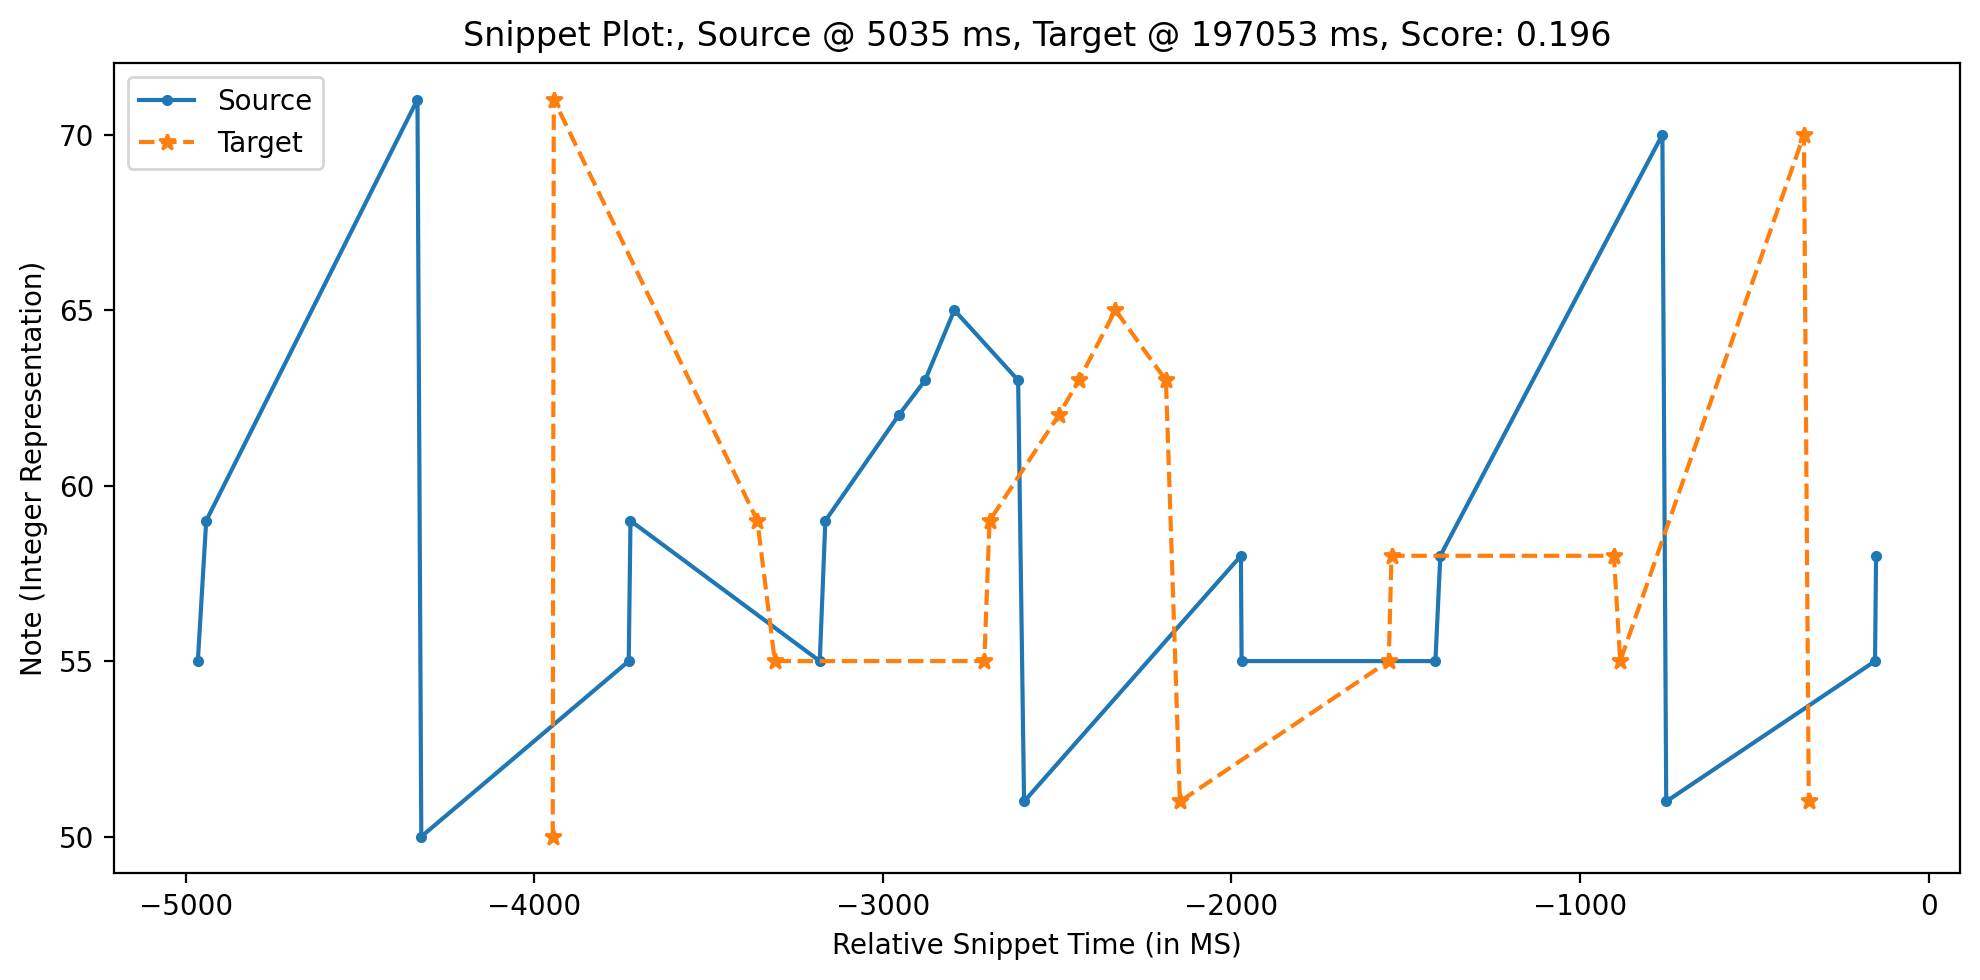

0.8461821782178218


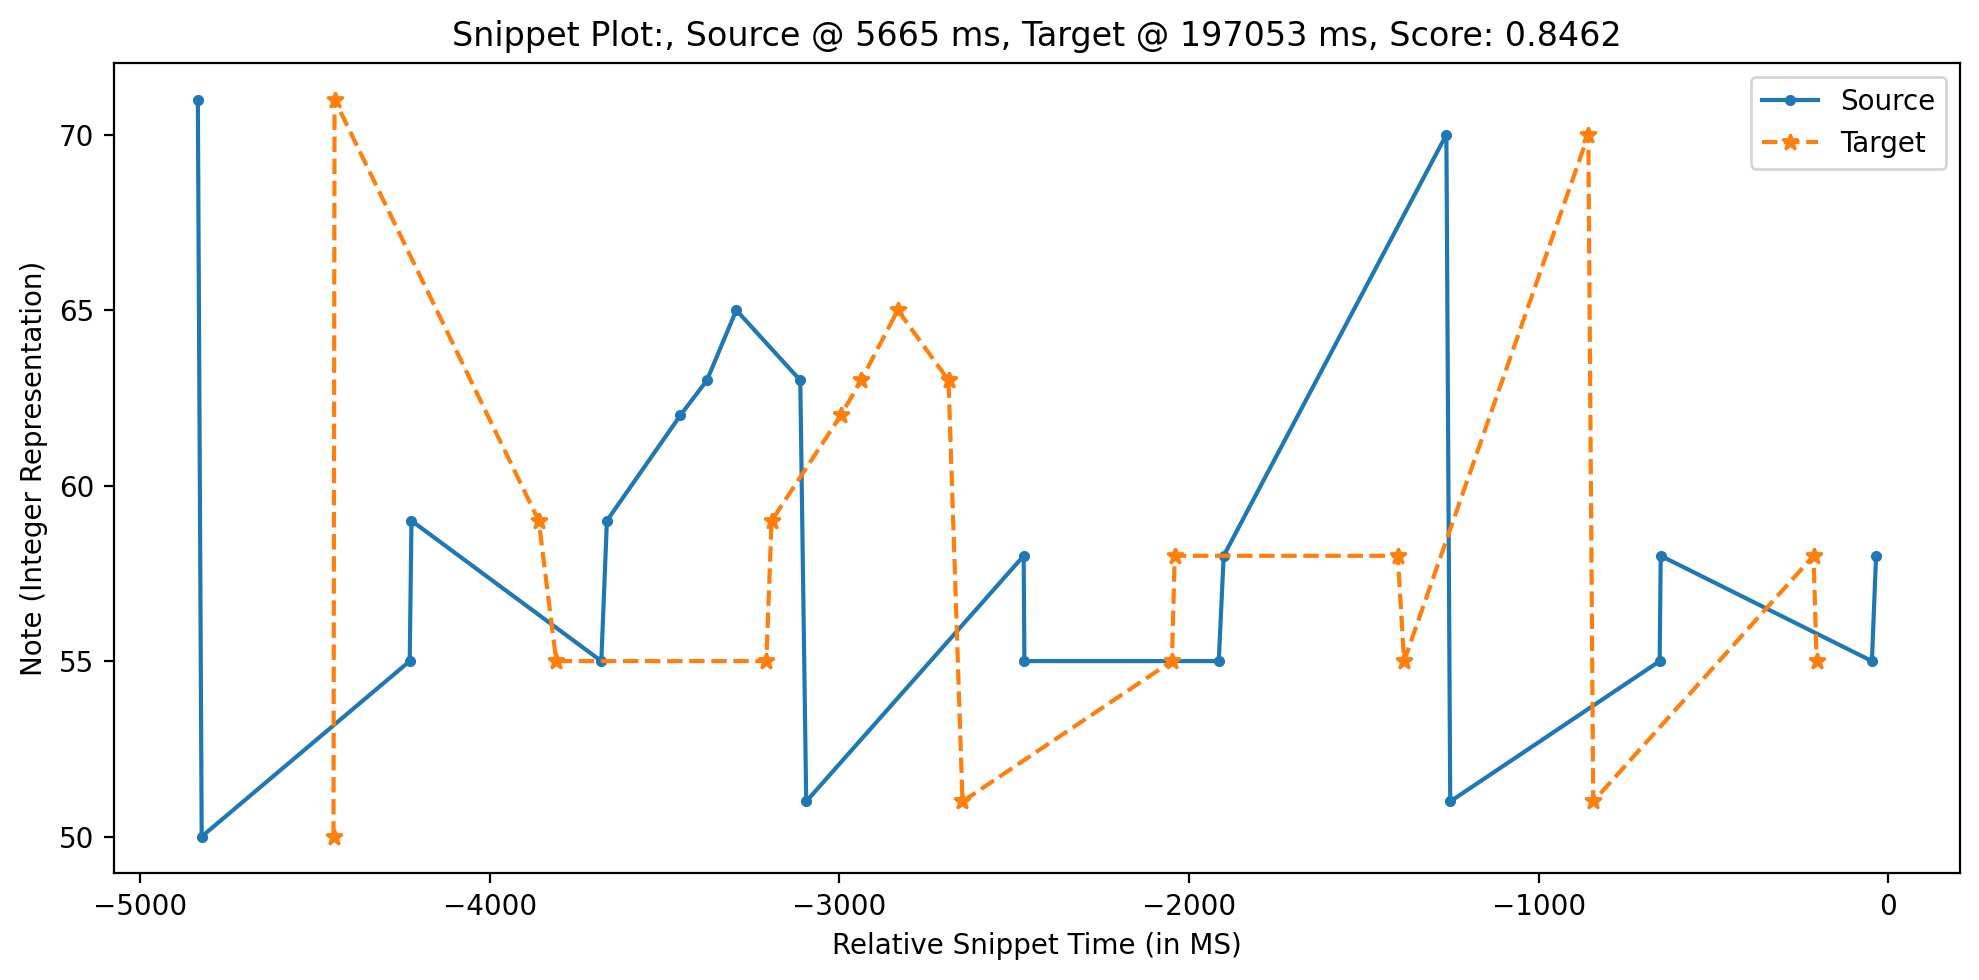

0.7916480715400993


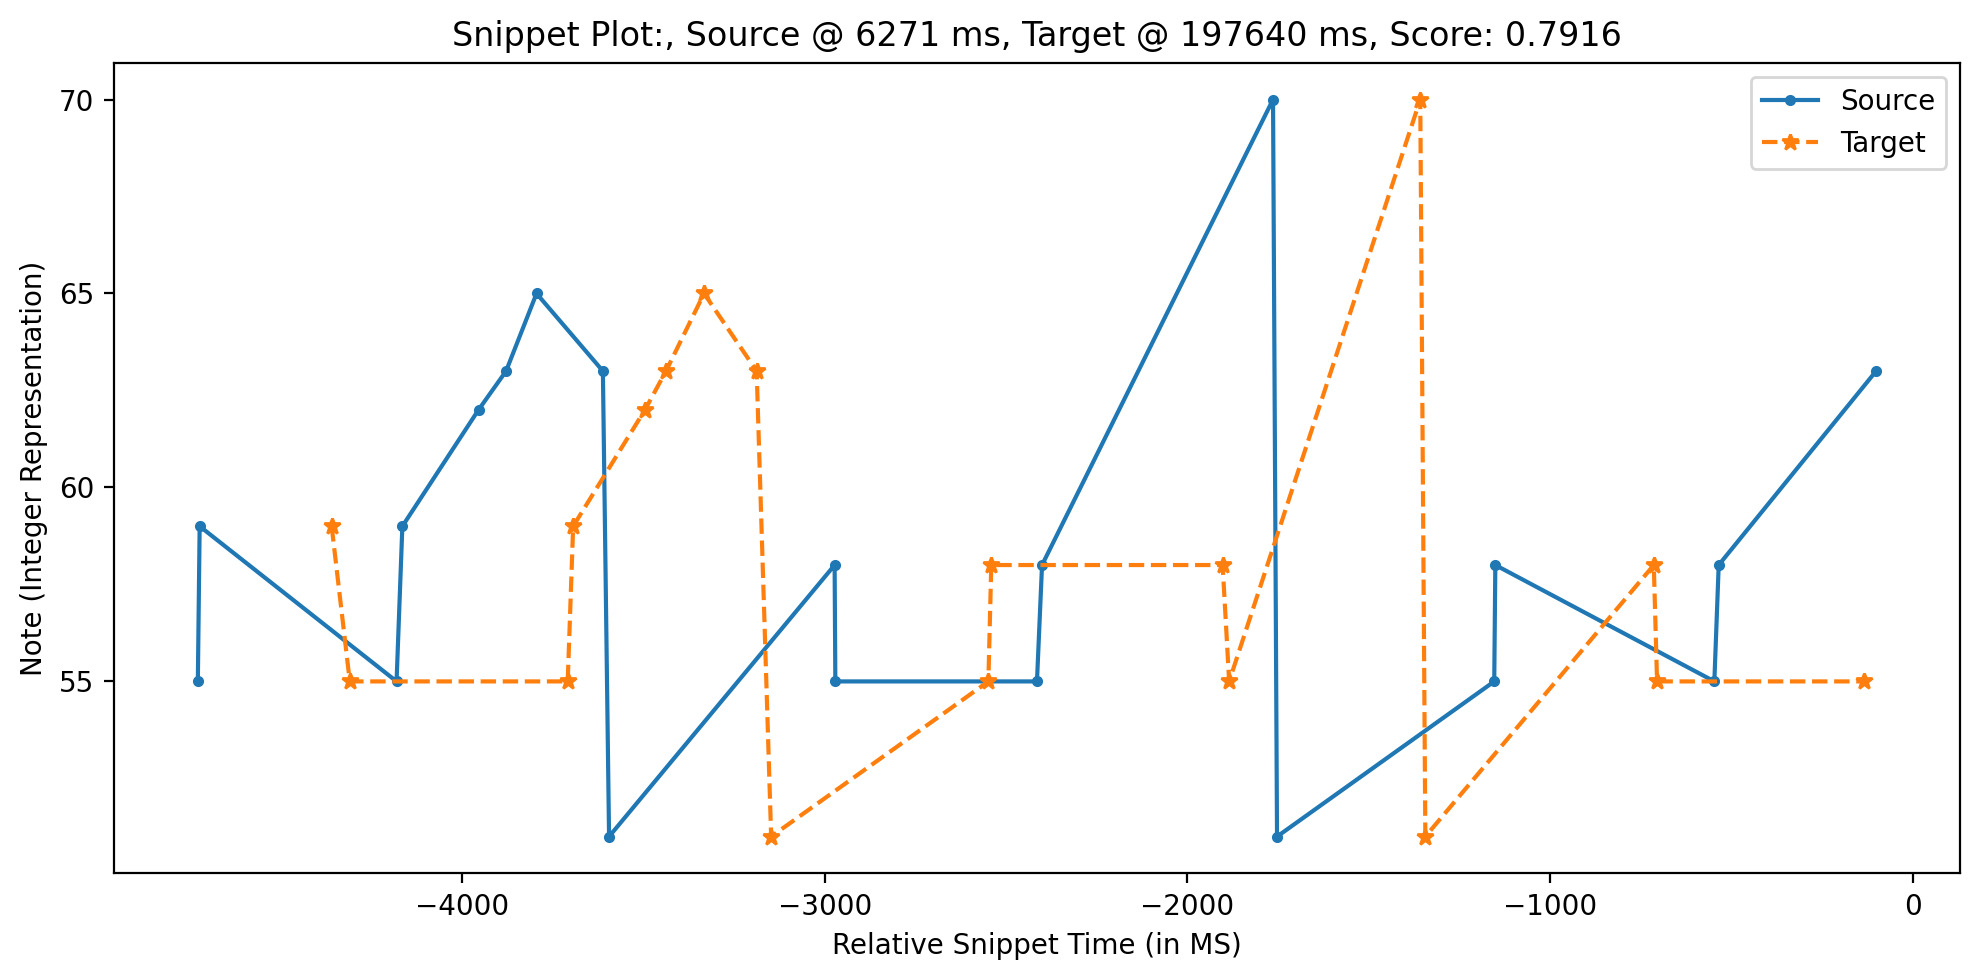

0.9366146585404687


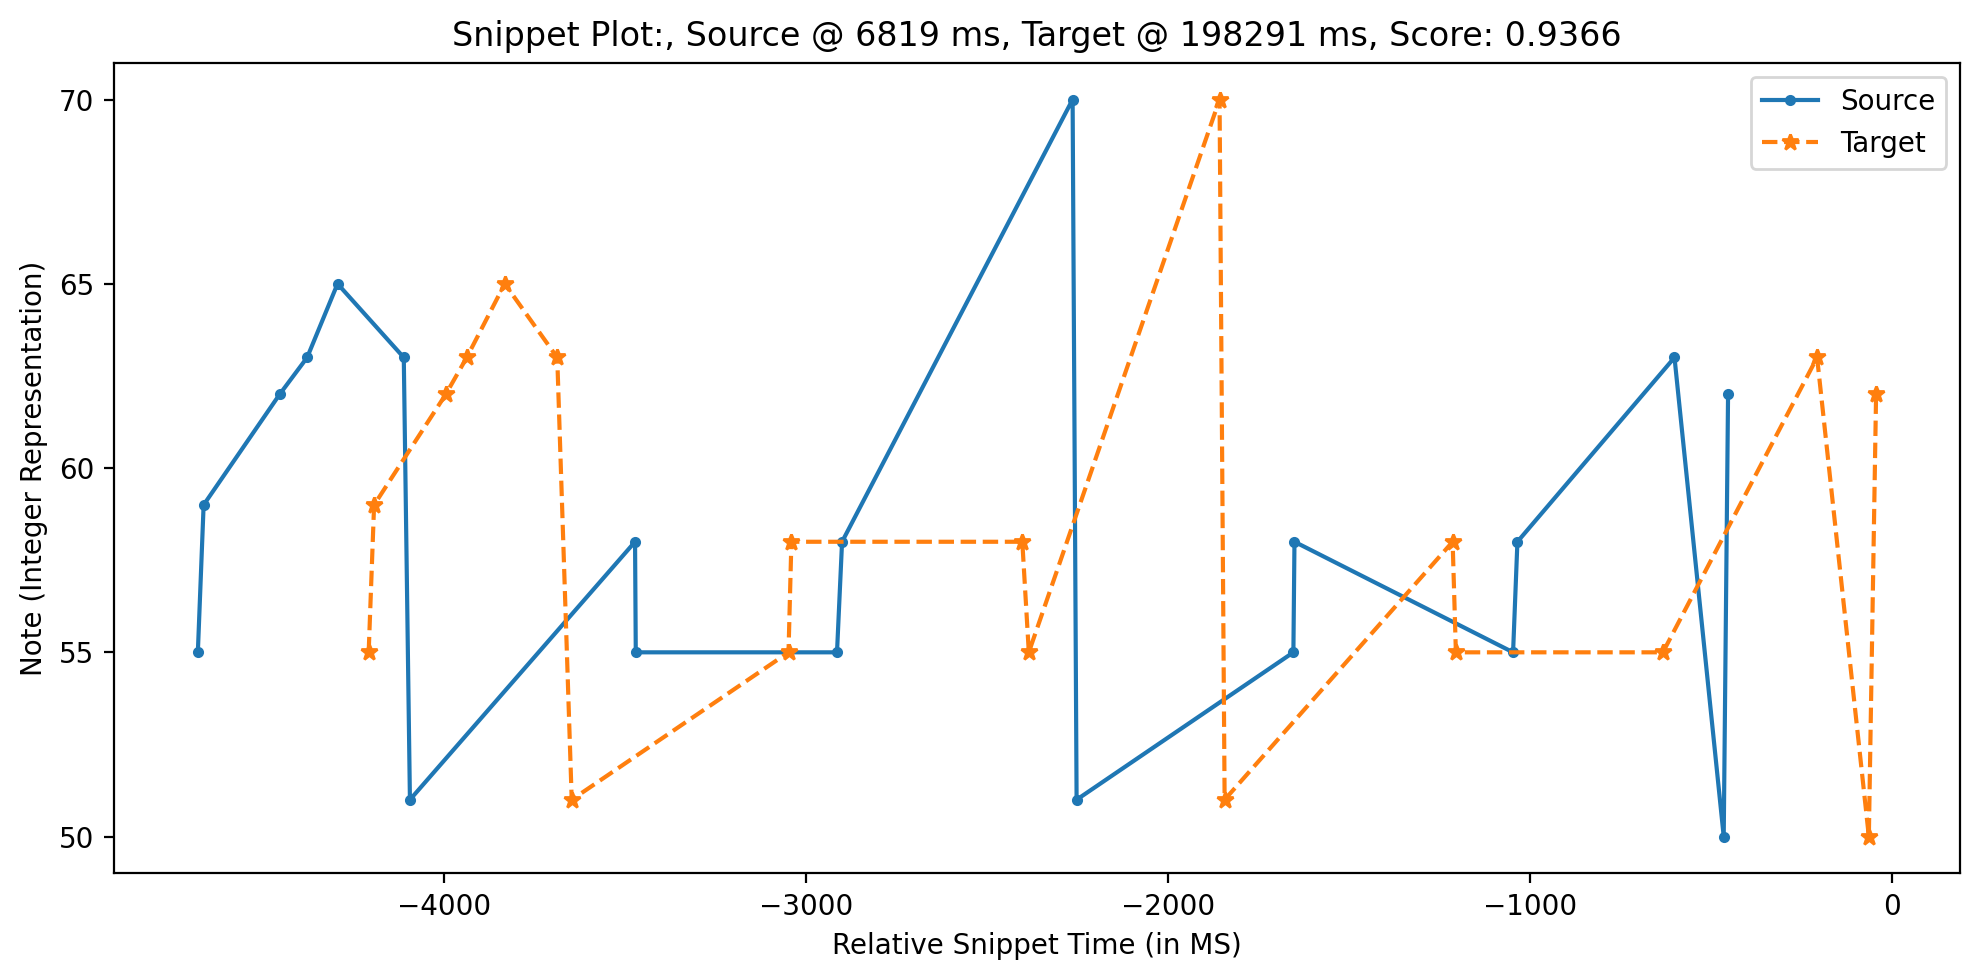

0.8874626240511134


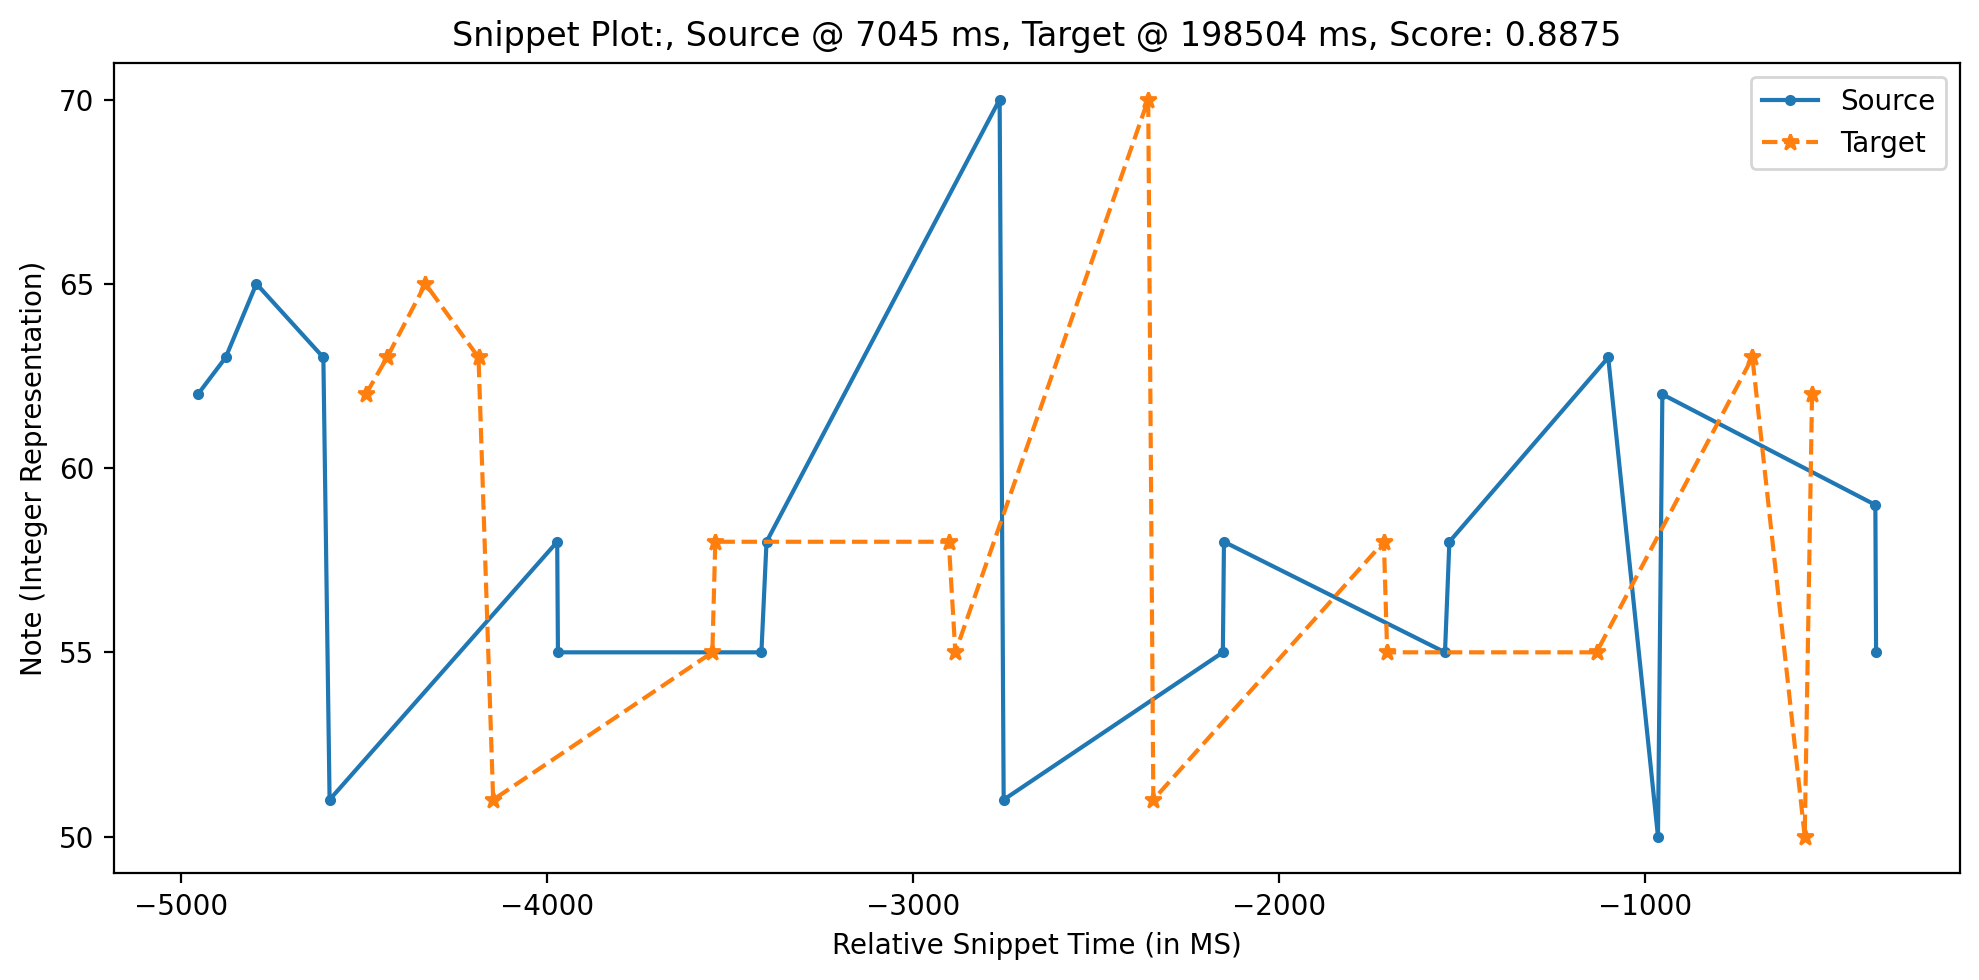

0.8876129496471303


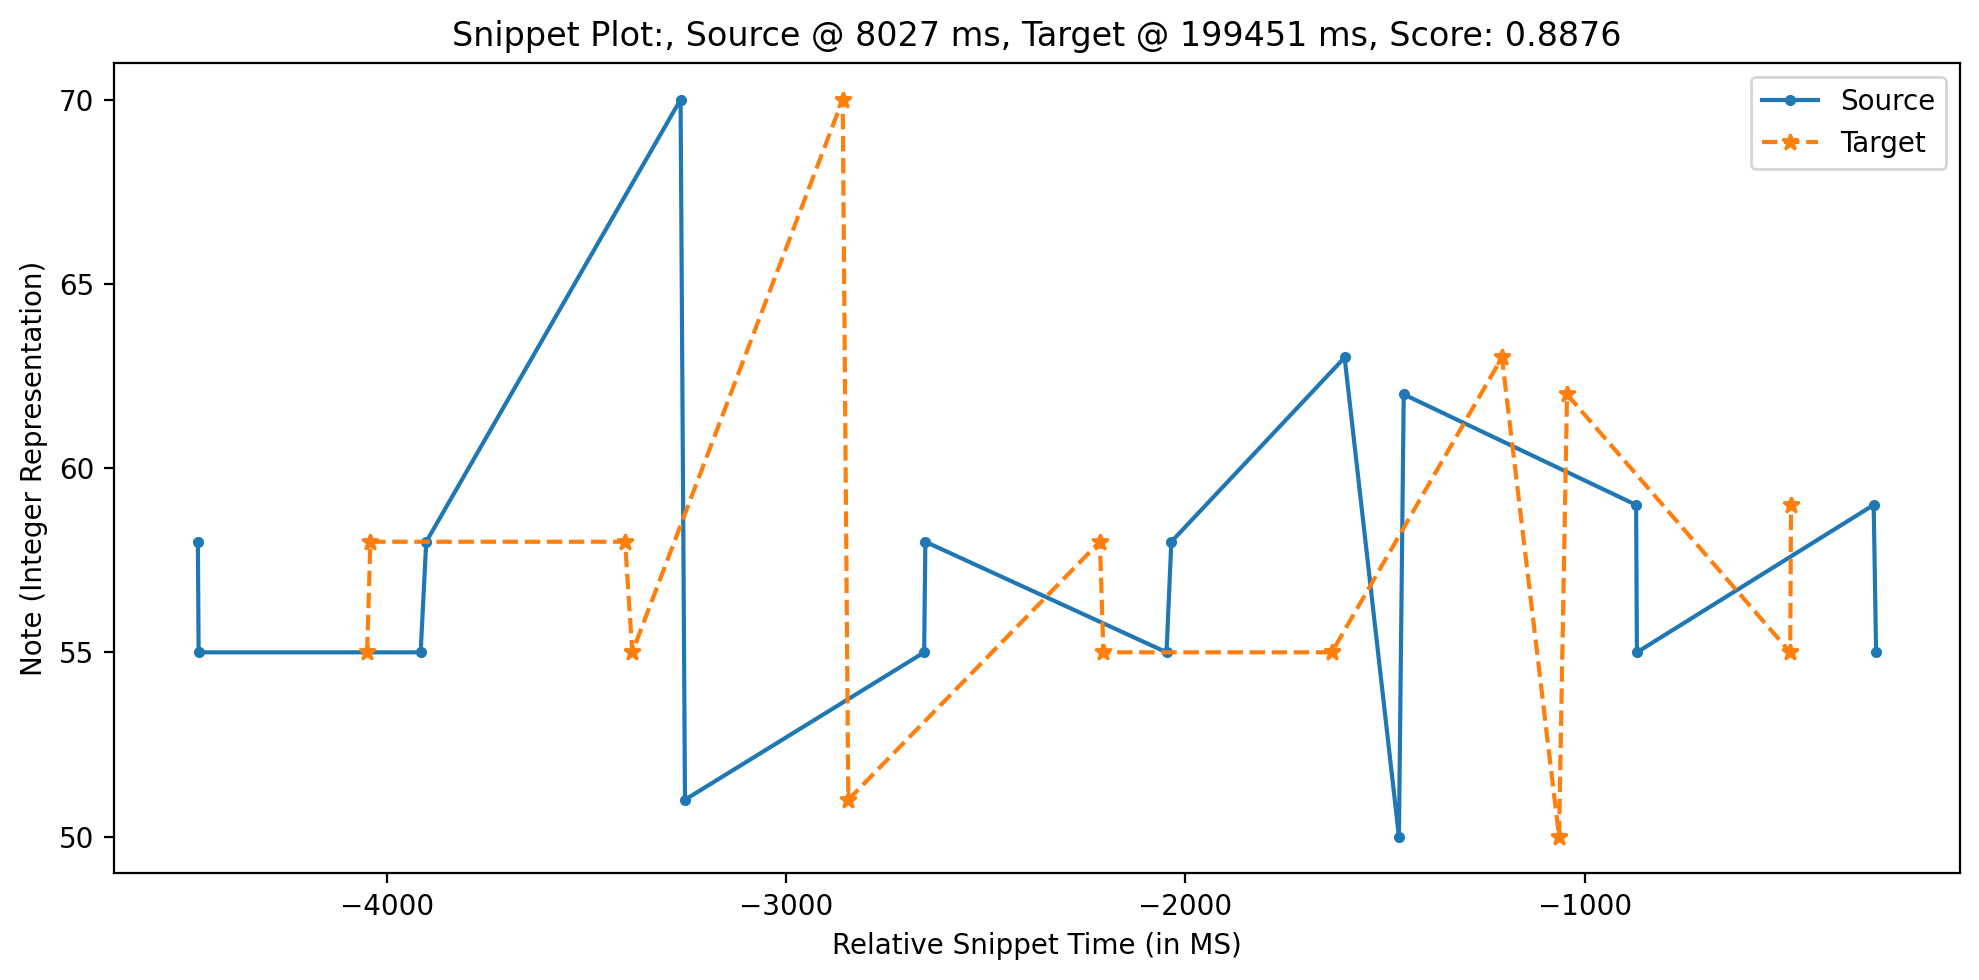

0.9073489795815014


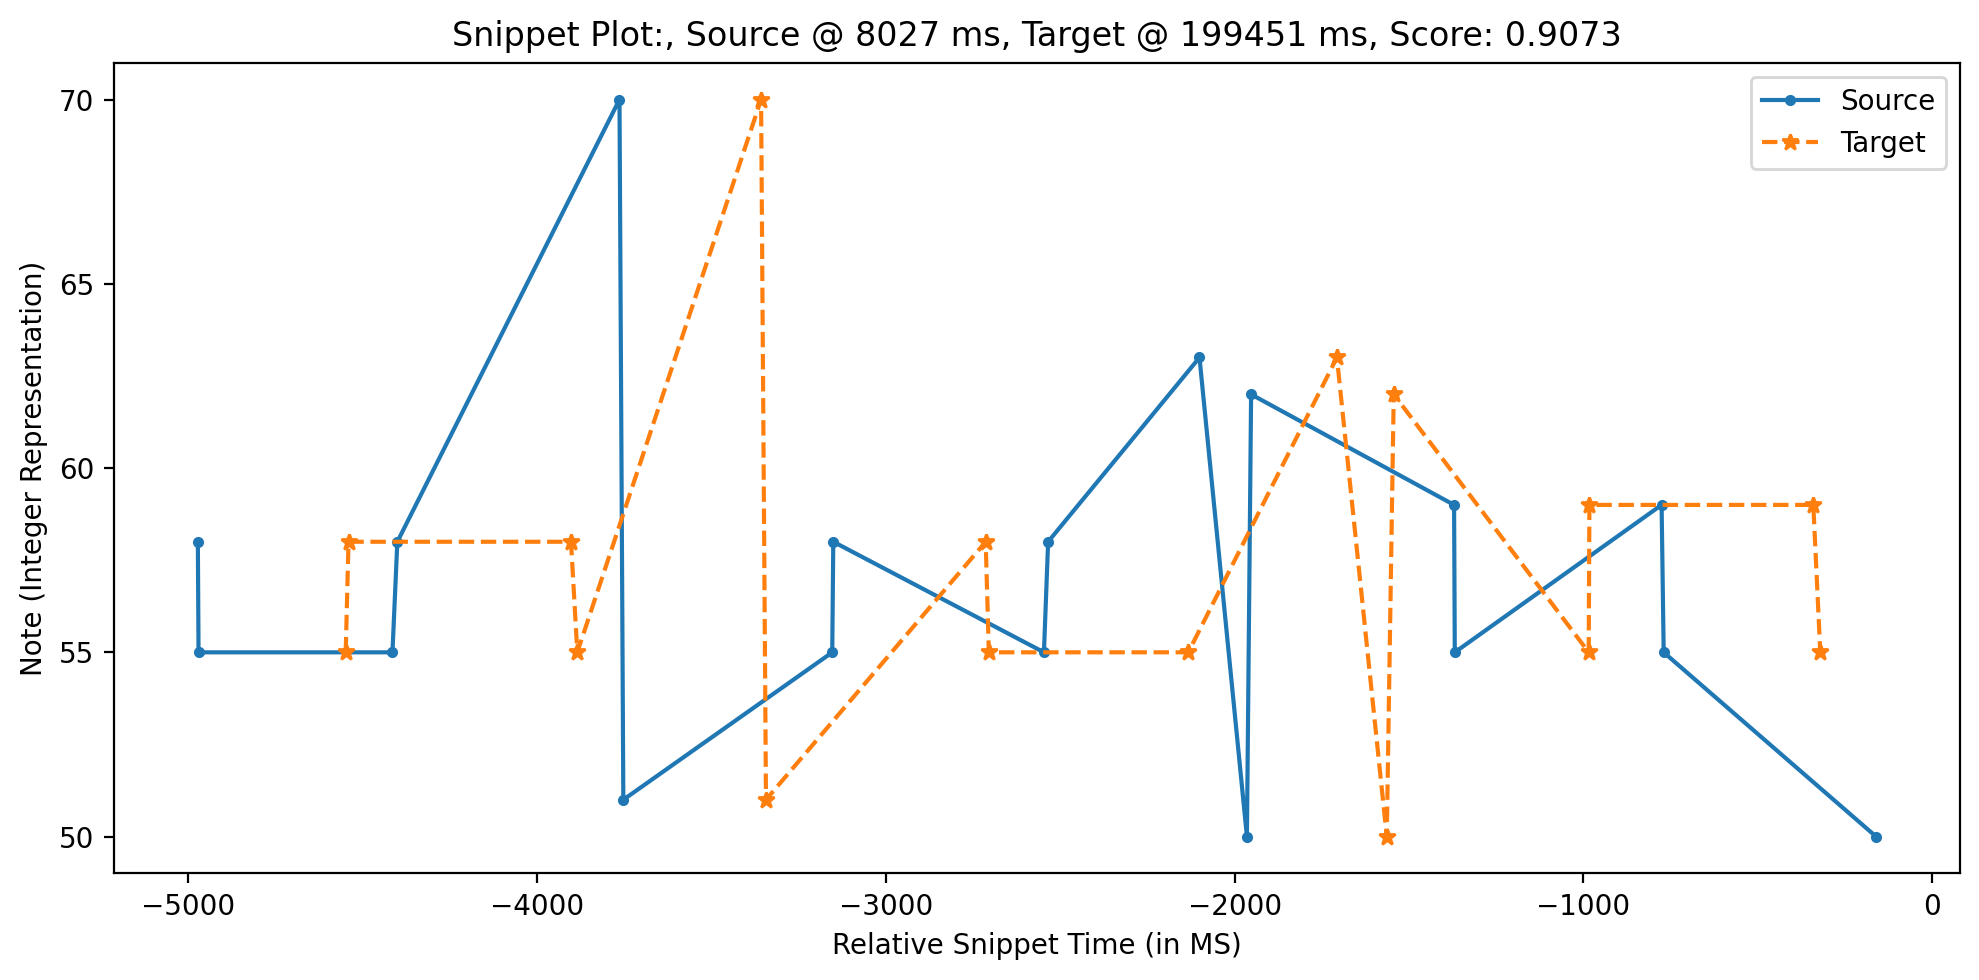

0.7236462748735263


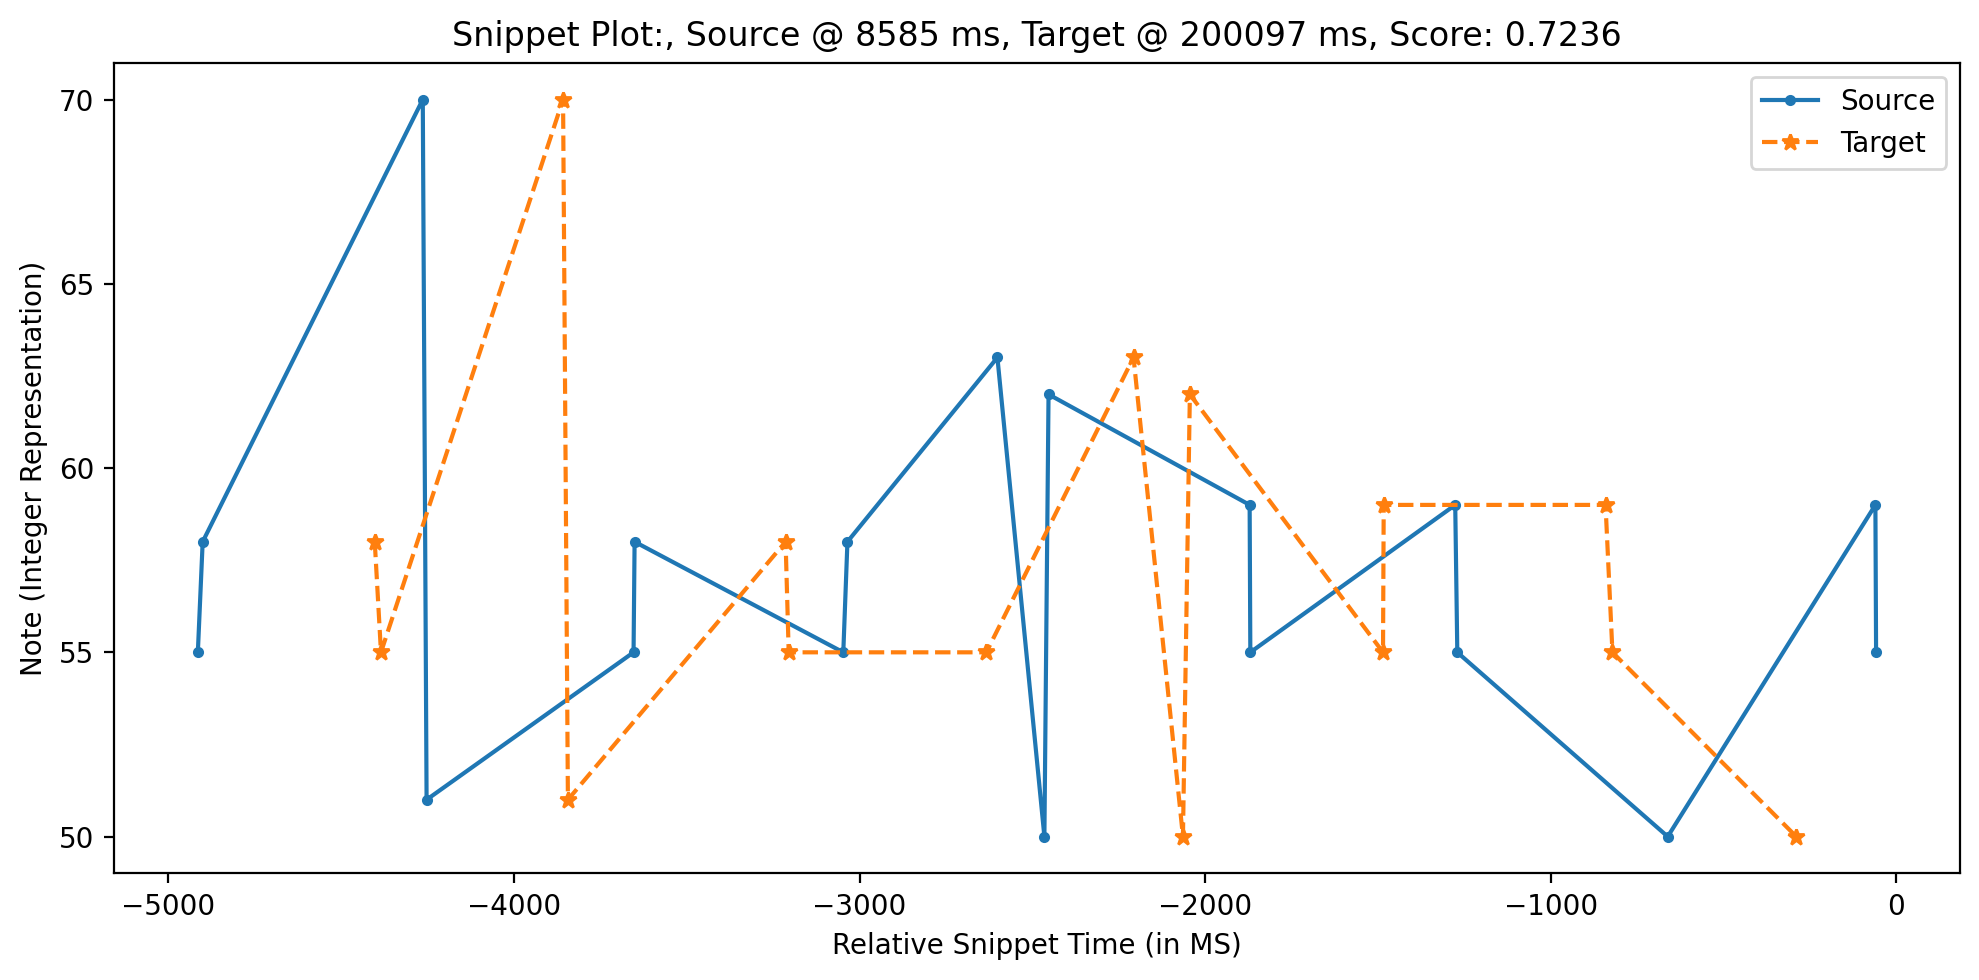

0.9974250966666665


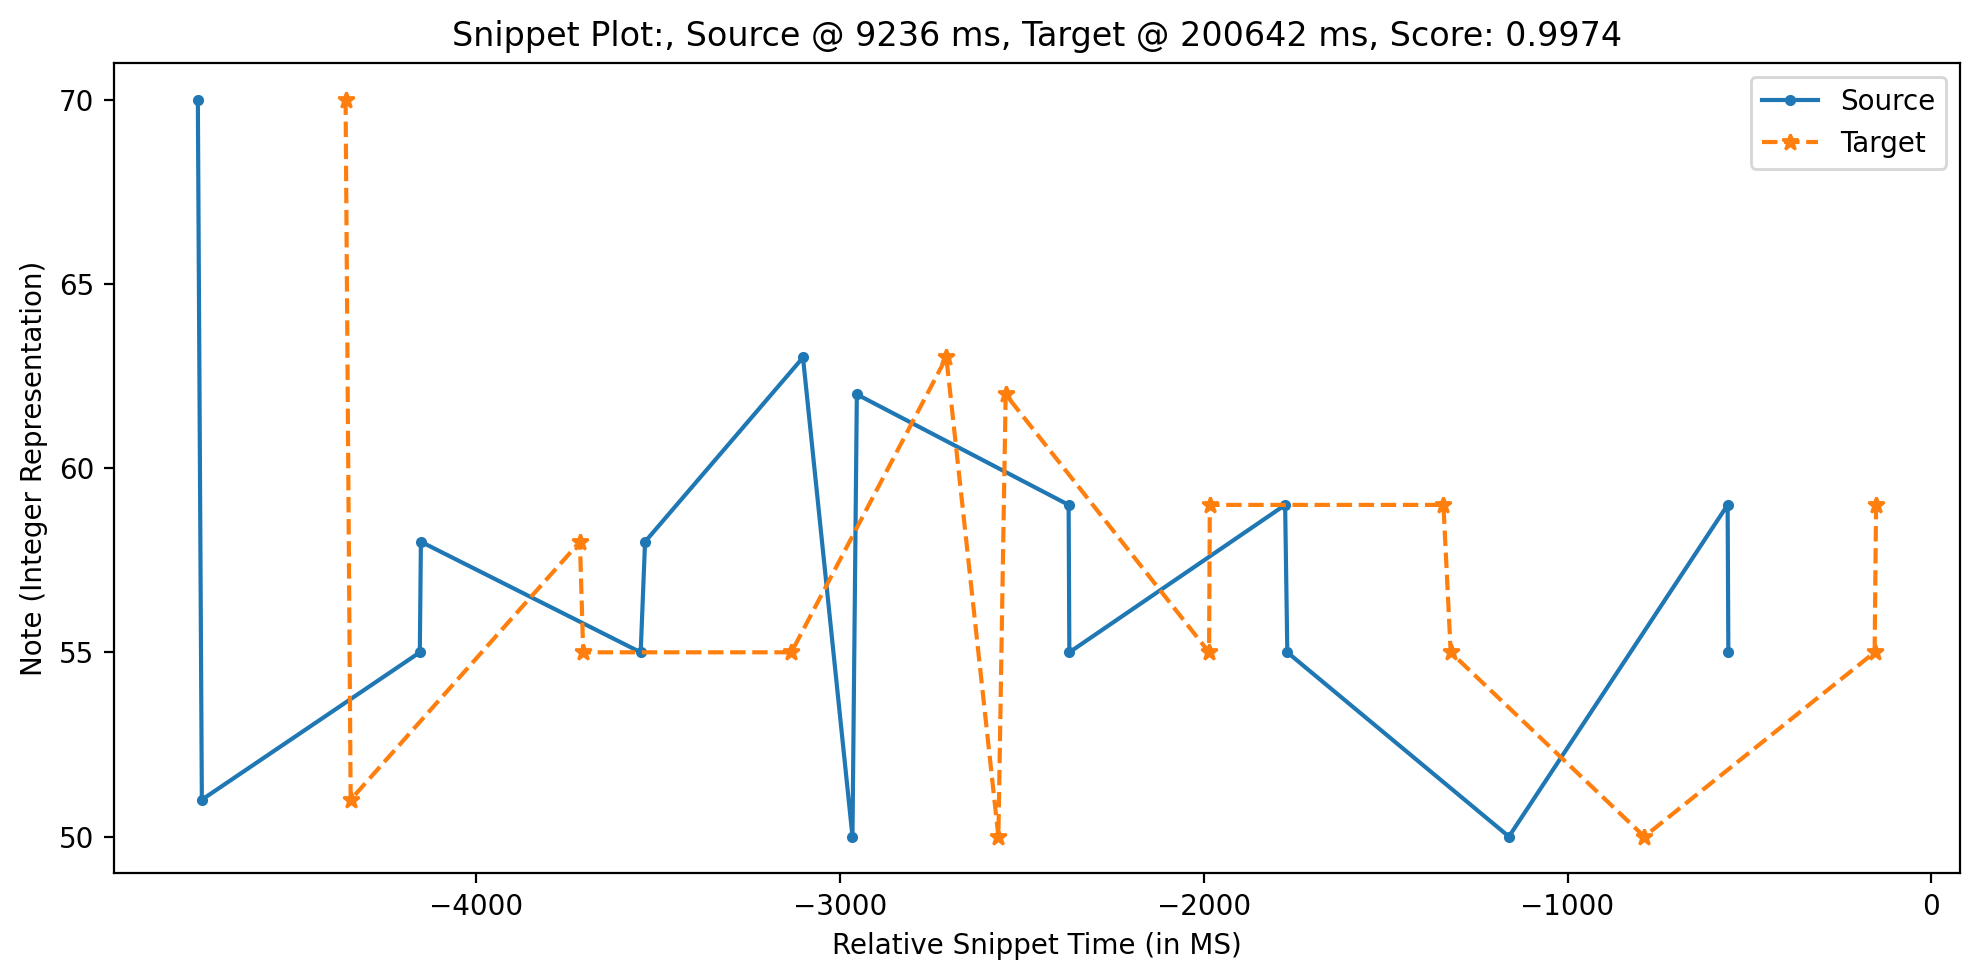

0.8917248718276991


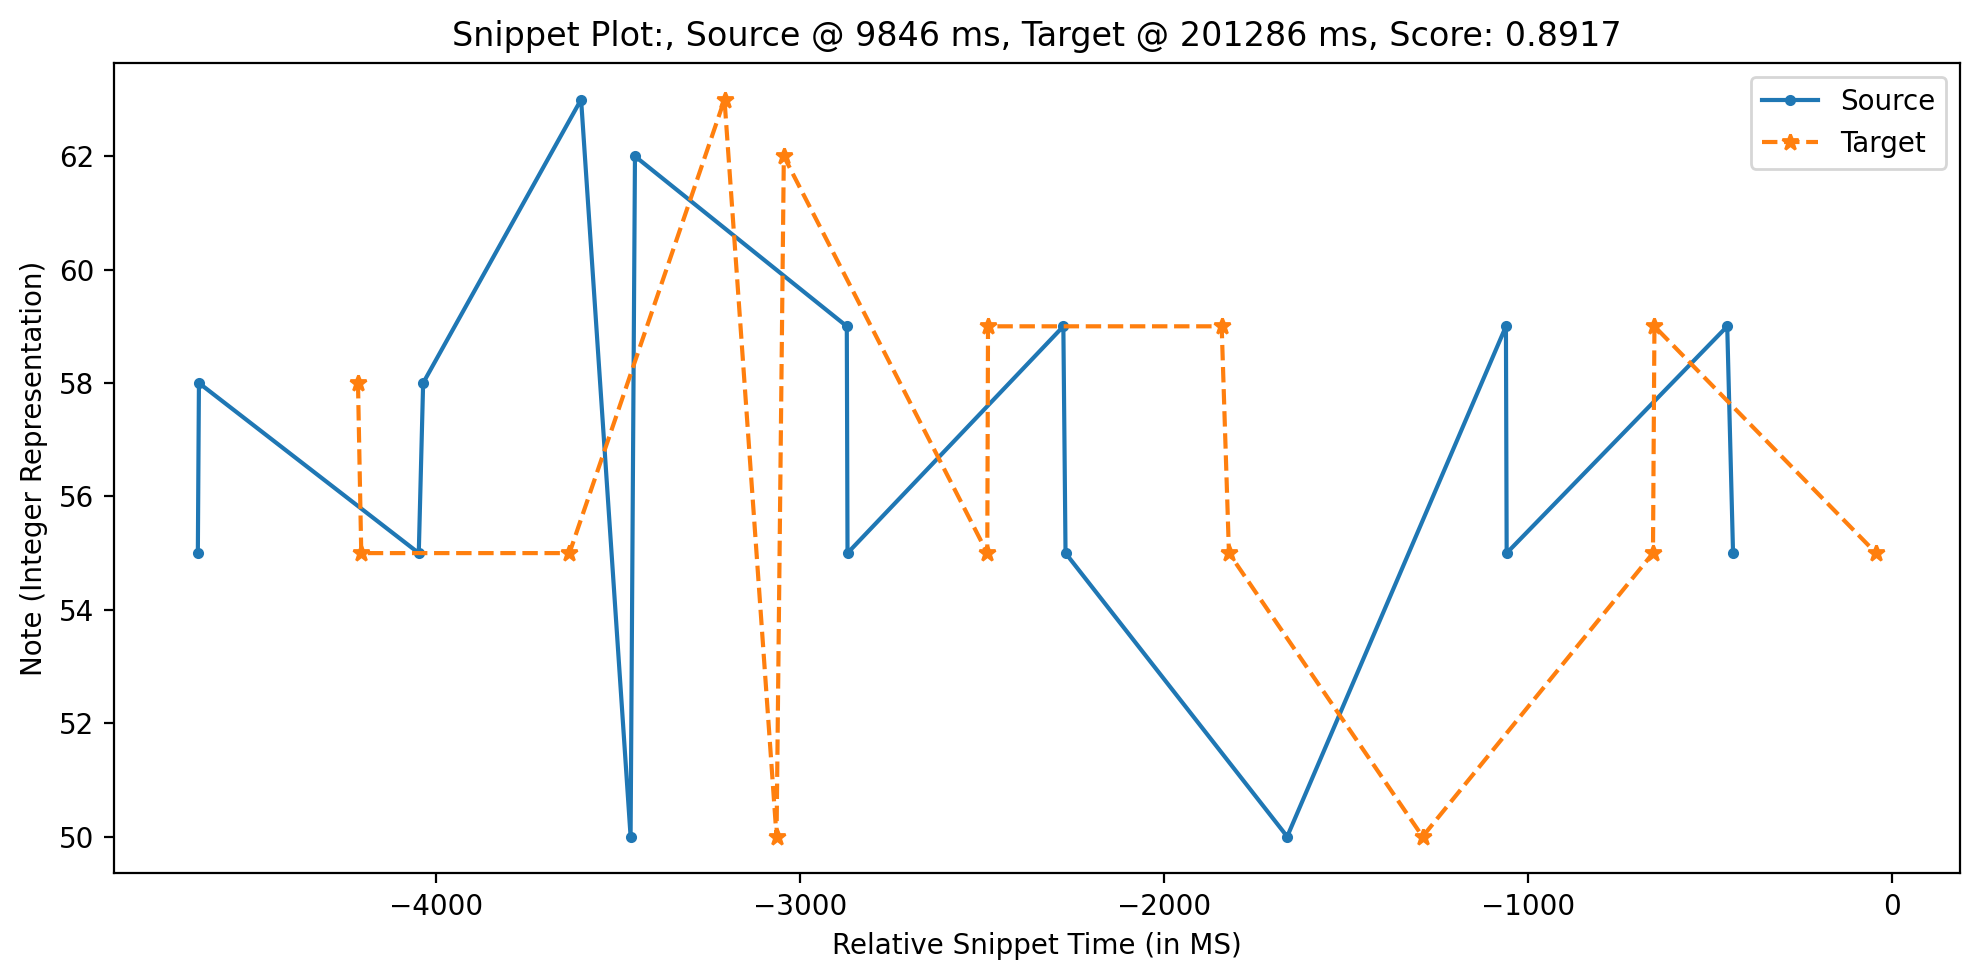

In [141]:
for x in range(0,10000,500):
#     x = 0
    t1 = [5000+x,0+x] # timestamps in ms
    t2 = [196000+x,191400+x]
#     t2 = [418000+x,413000+x]
#     t2 = [587000+x,587000+x]

    tf1 = time_to_sequence(notes, t1)
    tf2 = time_to_sequence(notes, t2)

    score = musical_similarity(tf1,tf2,disp=False)
    print(score)
#     if score<0.8:
    display_snippet_plot(notes, time_to_index(notes,t1[0]),time_to_index(notes,t1[1]),time_to_index(notes,t2[0]),time_to_index(notes,t2[1]), score, t1[0], t2[0])
#     play_match(t1[0],t1[1],t2[0],t2[1])
#     predict(notes, time_to_index(notes,t1[0]), time_to_index(notes,t1[1]), time_to_index(notes,t2[0]),time_to_index(notes,t2[1]), tf1[-1][0],pred_time=100,sound=True)
#     time.sleep(2)


In [142]:
# calculating similarity

# multiple matches
# sims_arr = []
# for i in range(minTime, snips[0][-1][0][0], 500):
# #     print("\r",end="")
# #     print("i:",i)
#     # only calculate on historical timestamps
#     source, targets = get_source_targets(snips, i, minNotes, maxNotes, minTime)
#     if not source:
#         continue
#     sim = calculate_similarity(source, targets, i)
#     for match in sim:
#         sims_arr.append(match)
        
# for a single match
percentage_matches_thresh = 0
percentage_matches_any = 0
sims_arr = []
source = 1
sourceId = 1
index = 0
for i in range(180000, 200000, minTime):
#     sims.append([])
    print("\r",end="")
    print("i:",i,end="   ")
    # only calculate on historical timestamps
    offset = 0
    count = notes[-1][0] + 1 # count number of relevant matches
    max_matches = 3 # if more matches, increase size of snippet
    while count > max_matches:
#         source, targets = get_source_targets(snips, i, minNotes, maxNotes, minTime + offset)
        sourceId = get_source_notes(notes, i, minNotes, maxNotes, minTime+offset)
        
        # num notes in source snippet
        # numSourceNotes = abs(sourceId[1] - sourceId[0])
        # total time in ms in source snippet
        # sourceTime = abs(notes[sourceId[1]][0] - notes[sourceId[0]][0])
        
        
        if not source or not sourceId:
            print("Failed for source = ",source, ", source_id = ", sourceId, ", on attempt ", (offset//500))
            if offset>0:
                percentage_matches_any += 1
            break
#         sim = calculate_similarity(source, targets, i)
#         sim = calculate_similarity_id(notes, sourceId, i)
        sim = calculate_similarity_time(notes, sourceId, i, disp=False)
        count = 0
        for match in sim:
            # match.append(numSourceNotes)
            # match.append(sourceTime)
            if match[2] > 0.9:
                count += 1
#         print("\b",end="")
#         print(len(targets))
        offset += 500
        
#     if count < 2:
#         print("Only 1 match found! (self)")
#         print("1 match",end=", ")
    if source and sourceId and sim:
        percentage_matches_any += 1
        flag = True
        for match in sim:
            sims_arr.append(match)
            if flag and match[2]>0.7:
                percentage_matches_thresh += 1
                flag = False
#     else:
#         sims_arr.append([i,0,0])
    
    index += 1
    
percentage_matches_thresh /= (notes[-1][0]/minTime)
percentage_matches_any /= (notes[-1][0]/minTime)
print("\n\nPercentage matches found: ", percentage_matches_any)
print("\n\nPercentage matches > 0.7 found: ", percentage_matches_thresh)


i: 199500   

Percentage matches found:  0.028795326929801107


Percentage matches > 0.7 found:  0.012340854398486189


In [ ]:
# choosing only significant scores and storing the new data in sims_plot

sims_arr = np.array(sims_arr)
sims_bool = sims_arr>0.7 # considering a match if score greater than a threshold
sims_plot = sims_arr * sims_bool
sims_plot

<AxesSubplot: title={'center': 'Min Snippet Length=8 notes, Max matches=3'}, xlabel='source_timestamp', ylabel='target_timestamp'>

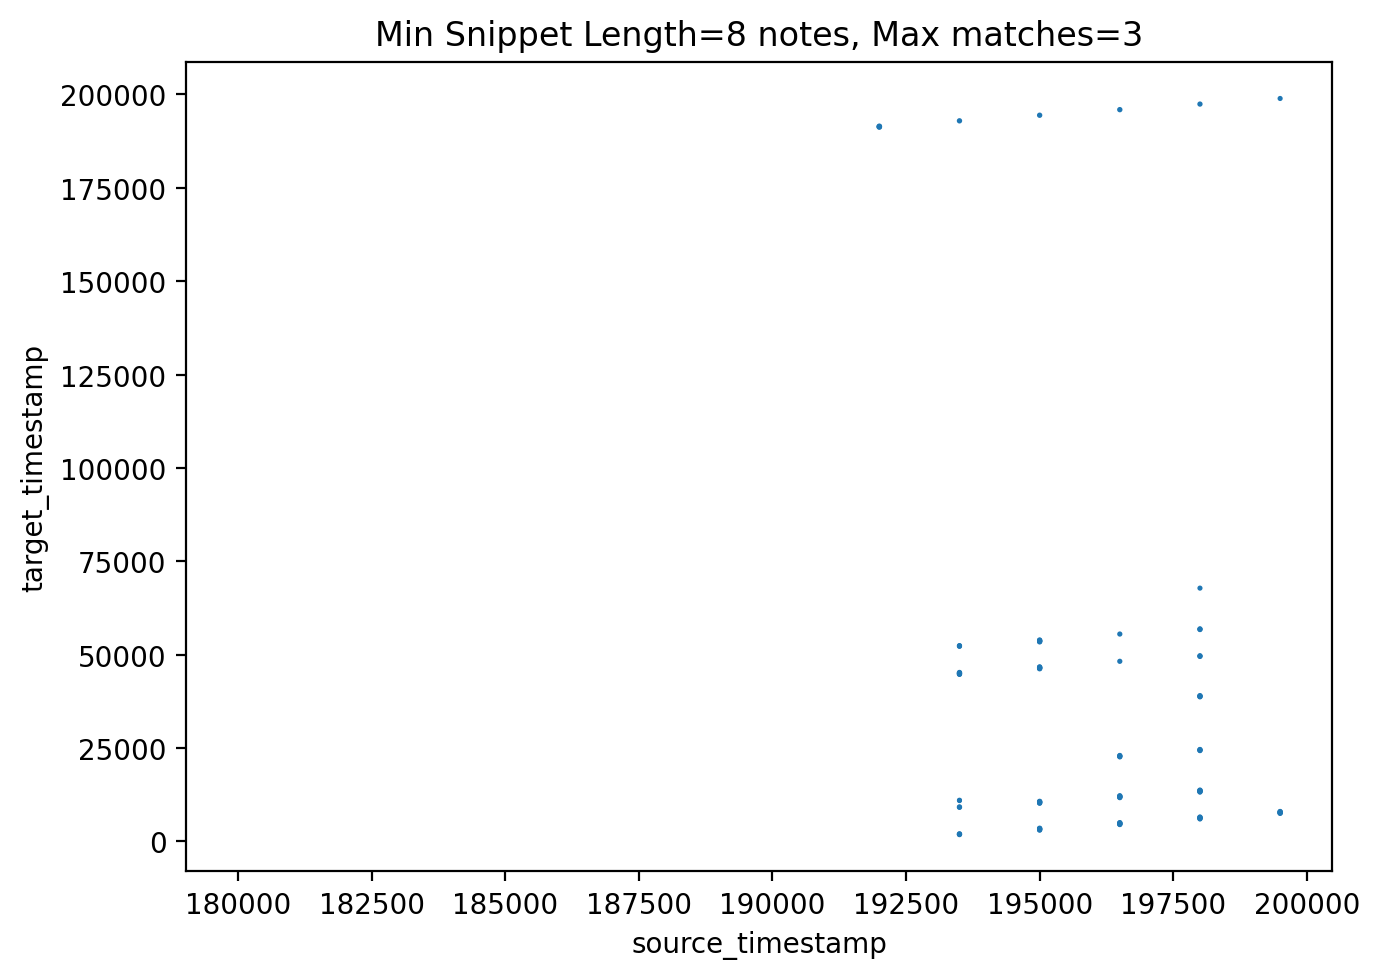

In [120]:
plt.rcParams["figure.figsize"] = [7, 5]
plt.rcParams["figure.autolayout"] = True

simsDF = pd.DataFrame(data=sims_plot, columns=['source_timestamp', 'target_timestamp','score'])
title = "Min Snippet Length=" + str(minNotes) + " notes, Max matches=" + str(max_matches)
simsDF.plot.scatter(x="source_timestamp", y="target_timestamp", s='score', title=title)

In [24]:
# Plotting best match only

simsDF = pd.DataFrame(data=sims_arr, columns=['source_timestamp', 'target_timestamp','score', 'matchNoteLen', 'matchTimeLen'])
count = 0
for x in range(minTime, notes[-1][0], minTime):
    y = simsDF.loc[simsDF['source_timestamp'] == x]['score'].max()
    plt.scatter(simsDF['source_timestamp'].loc[y],simsDF['target_timestamp'].loc[y],simsDF['score'].loc[y],c='blue')
    
plt.show()

KeyError: nan

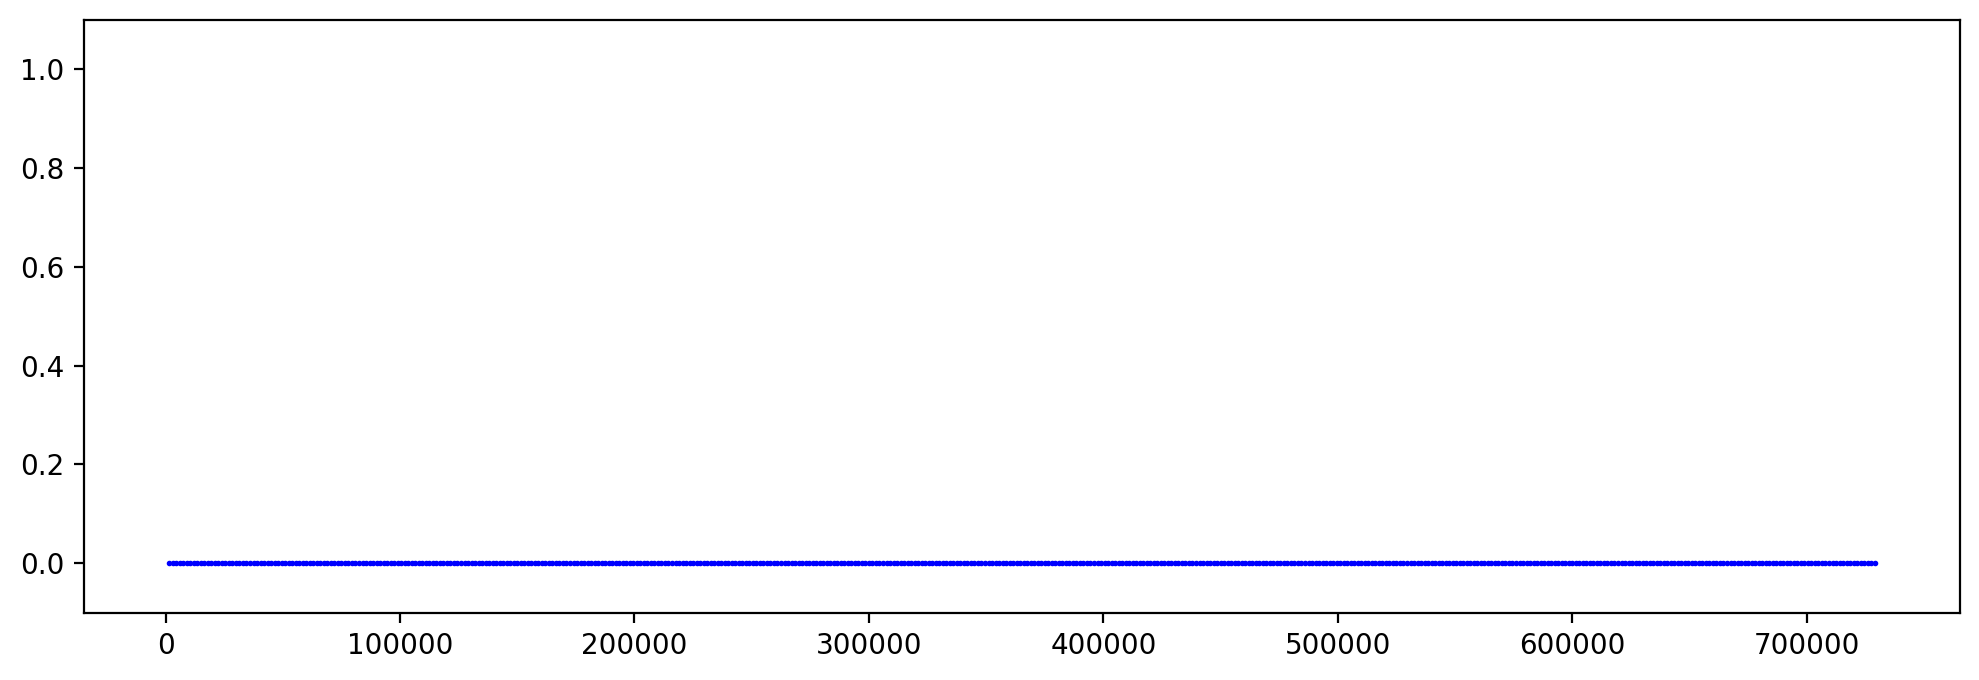

In [23]:
# Plotting best match score 

plt.rcParams["figure.figsize"] = [10, 3.50]
plt.rcParams["figure.autolayout"] = True

simsDF = pd.DataFrame(data=sims_arr, columns=['source_timestamp', 'target_timestamp','score','matchNoteLen', 'matchTimeLen'])
count = 0
for x in range(minTime, notes[-1][0], minTime):
    y = simsDF.loc[simsDF['source_timestamp'] == x]['score'].max()
    if math.isnan(y):
        count += 1
        y = 0
    plt.scatter(x,y,1,c='blue')
    
# print(count)
plt.ylim(-0.1, 1.1)
plt.show()

---

### RMS Time Difference Calculation

In [18]:
# Plotting best match only

simsDF = pd.DataFrame(data=sims_arr, columns=['source_timestamp', 'target_timestamp','score'])
count = 0
matches = []
for x in range(minTime, notes[-1][0], minTime):
    y = simsDF.loc[simsDF['source_timestamp'] == x]['score'].idxmax()
    match = [second['source_timestamp'].loc[y],second['target_timestamp'].loc[y],second['score'].loc[y]]
    matches.append(match)
matches = np.array(matches)
matchesDF = pd.DataFrame(data = matches, columns=['source_timestamp', 'target_timestamp','score'])

ValueError: Shape of passed values is (272949, 5), indices imply (272949, 3)

In [19]:
# RMS Difference: 
# Root Mean Square Time Difference is defined as the RMS difference between each pair of notes in the top match
# E.g. if the top match with the highest similarity score finds a candidate match c = (c1, c2, c3, c4) to the source s = (t1, t2, t3, t4) of 4 notes
# Then the difference for this match is calculated as the difference in MS of c1 to t1, c2 to t2, c3 to t3, and c4 to t4:
# Then RMS difference is the square root of the mean of the sum of all differences between two MS time ranges

# For the whole run playthrough, time range is from 0 ms to 734264 ms
matchesArr = np.array(matchesDF)
msArr = []
sumMS = 0
constantMult = 500.0

for i in range(matchesDF.shape[0]):
    ms = (1- matchesArr[i][2]) / constantMult
    msArr.append(ms)
    sumMS += (ms)
msArr = np.array(msArr)
rmsWhole = sumMS / msArr.shape[0]

print("Whole Playthrough RMS Difference (in ms): ", rmsWhole)

NameError: name 'matchesDF' is not defined

In [ ]:
# For the second run playthrough, time range is from 180000 ms to 370000 ms
secondRun = matchesDF[(matchesDF.source_timestamp > 180000) & (matchesDF.source_timestamp < 370000)]

secondArr = np.array(secondRun)
ms2Arr = []
sum2MS = 0

for i in range(secondRun.shape[0]):
    ms = (1- secondArr[i][2]) / constantMult
    ms2Arr.append(ms)
    sum2MS += (ms)
ms2Arr = np.array(ms2Arr)
rmsSecond = sum2MS / ms2Arr.shape[0]

print("Second Run Playthrough RMS Difference (in ms): ", rmsSecond)

In [ ]:
# For the third run playthrough, time range is from 412713 ms to 565238 ms
thirdRun = matchesDF[(matchesDF.source_timestamp > 412713) & (matchesDF.source_timestamp < 565238)]

thirdArr = np.array(thirdRun)
ms3Arr = []
sum3MS = 0

for i in range(thirdRun.shape[0]):
    ms = (1- thirdArr[i][2]) / constantMult
    ms3Arr.append(ms)
    sum3MS += (ms)
ms3Arr = np.array(ms3Arr)
rmsThird = sum3MS / ms3Arr.shape[0]

print("Third Run Playthrough RMS Difference (in ms): ", rmsThird)

In [ ]:
# For the fourth run playthrough, time range is from 587616 ms to 734264 ms
fourthRun = matchesDF[(matchesDF.source_timestamp > 587616) & (matchesDF.source_timestamp < 734264)]

fourthArr = np.array(fourthRun)
ms4Arr = []
sum4MS = 0

for i in range(thirdRun.shape[0]):
    ms = (1- fourthArr[i][2]) / constantMult
    ms4Arr.append(ms)
    sum4MS += (ms)
ms4Arr = np.array(ms4Arr)
rmsFourth = sum4MS / ms4Arr.shape[0]

print("Fourth Run Playthrough RMS Difference (in ms): ", rmsFourth)